## v1.1 of the Sanity Test Notebook

This has the model validation tests for the paper, with the current version of the analysis & updated treatment of simulated signals.

Features:
- "bootstrap" empirical relation error (really need a new name...)
- full formalism
- M prior matching M range
- p_0(M) and p(M) are assumed to be identical and uniform
- Updated simulation of signals. Now uses same prior & treatment as analysis of 'real' data
- no redshift corrections!

In [334]:
## point to my utils/analysis code
hbpmloc = '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm_v2/'
## basic imports
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import scipy.stats as st
import matplotlib
import matplotlib.lines as mlines
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde as kde
from scipy.stats.mstats import mquantiles as mq
from scipy.signal import medfilt
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde
from glob import glob
import pandas as pd
import sys 
import os
import pickle

## Importing the accompanying utility and analysis files
sys.path.append(os.path.abspath(hbpmloc+'hbpm_utils/'))
from hbpm_utils import *
from importlib import reload
reload(sys.modules["hbpm_utils"])
from hbpm_utils import *
sys.path.append(hbpmloc)
from hbpm_analysis import run_analysis
reload(sys.modules["hbpm_analysis"])
from hbpm_analysis import run_analysis

## my preferred figure settings
matplotlib.rcParams['figure.figsize'] = (8.08, 5.)
matplotlib.rcParams['xtick.labelsize'] = 16.0
matplotlib.rcParams['ytick.labelsize'] = 16.0
matplotlib.rcParams['axes.labelsize'] = 18.0
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["mediumorchid", "teal", "goldenrod","slategray"])

## Preliminaries

In [430]:
## set KDE bandwidth
bandwidth = 0.15
prior_bandwidth = bandwidth

In [431]:
## load the not-bootstrap bootstrap
## really need a new name for this
## should also make a function to do this & put the samples in the hbpm_v2 directory
coeffs = pd.read_csv(
    '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm/analysis_2022/empirical_relation_samples/sampled_coefficients_v05.tab',
    sep=' ')
bootstrap = coeffs.to_numpy()

In [432]:
## fine grid
fs = np.linspace(1.5,4,200)
Ms = np.linspace(0.8,1.8,200)
Rs = np.linspace(9,15,200)

In [6]:
## get fpeak prior
fprior_path = hbpmloc+'priors/fpeak_broad_noise_prior.txt'
fprior_samples = np.loadtxt(fprior_path)
fprior = Prior_f(fprior_samples,boundary='Reflection',kde_bandwidth=prior_bandwidth)

In [7]:
## make uniform R16 prior
Rprior_kernel = st.uniform(loc=9,scale=6)

In [433]:
## set random state
rng = np.random.default_rng(170817)

## Tests

Tests needed:
- Uninformative data (doubling as our reference signalless distributions)
- Tests w/ increasing signal strength for 100 signals
- For weak signal limit, evolution w/ N_events

#### Generate Simulated 100-event Population

In [434]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 50
nnoise = 5000

In [435]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N = 100
m1s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
m2s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
Mlist = calc_Mchirp(m1s,m2s)

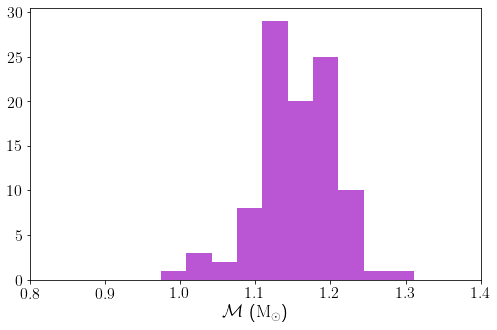

In [436]:
plt.figure()
plt.hist(Mlist)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

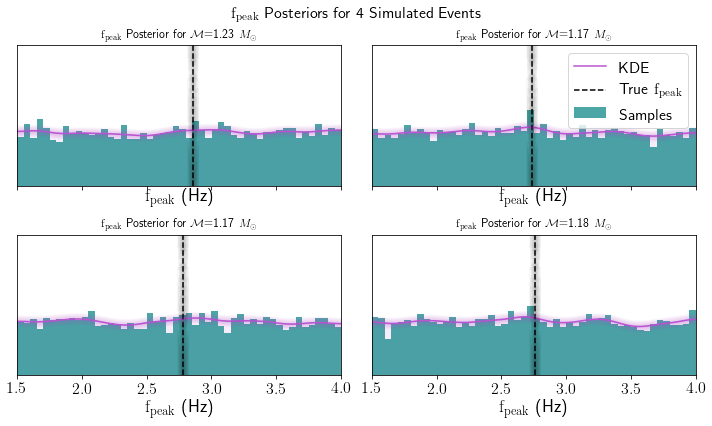

In [405]:
## make sure gen_simulated_eventdict() works lol
sim_evd = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

In [437]:
Mf_list = np.array([[sim_evd[key]['mchirp'],sim_evd[key]['ftrue']] for key in sim_evd.keys()])

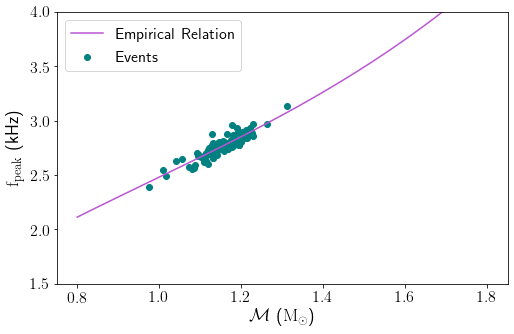

In [438]:
plt.figure()
plt.plot(Ms,empirical_relation_f(Rtrue,Ms),label='Empirical Relation')
plt.scatter(Mf_list[:,0],Mf_list[:,1],label='Events',color='teal')
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.ylabel('$\mathrm{f_{peak}}$ (kHz)')
plt.ylim(1.5,4)
plt.legend()
plt.show()

#### Uninformative Data

NB - doing N=10 for now. Once everything is in order and working, redo w/ N=100 for final plots.

In [14]:
Nloop = 10
noise_likelist = []
for i in range(Nloop):
    print("Processing {}/{}".format(i+1,Nloop))
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='none',glow=True,saveto=None,showplot=False,nosignal=True)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                               Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    noise_likelist.append(test_likes_i)
# orchid_line = mlines.Line2D([], [], color='mediumorchid',alpha=0.7,label='Weak-Signal $\mathrm{R_{1.6}}$ Posteriors')

Processing 1/10
Processing 2/10
Processing 3/10
Processing 4/10
Processing 5/10
Processing 6/10
Processing 7/10
Processing 8/10
Processing 9/10
Processing 10/10


In [15]:
noise_postlist = []
for like_i in noise_likelist:
    noise_postlist.append(get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel))

In [16]:
np.savetxt('noise_only_R16post_10x100events.txt',noise_postlist)

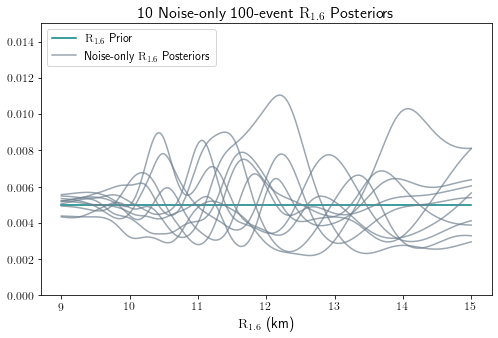

In [17]:
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('{} Noise-only '.format(Nloop)+'100-event $\mathrm{R_{1.6}}$ Posteriors')
# plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
for like_i in noise_likelist:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.7,label='_nolegend_')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[grey_line],loc='upper left')
# plt.gca().set_yticks([])
plt.ylim(0,0.015)
plt.savefig('./paper/figures/modval_noiseonly.pdf',bbox_inches='tight')
plt.savefig('./paper/figures/modval_noiseonly.png',bbox_inches='tight')
plt.show()

In [18]:
Nloop = 100
noise_likelist100 = []
for i in range(Nloop):
    print("Processing {}/{}".format(i+1,Nloop))
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='none',glow=True,saveto=None,showplot=False,nosignal=True)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                               Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    noise_likelist100.append(test_likes_i)
# orchid_line = mlines.Line2D([], [], color='mediumorchid',alpha=0.7,label='Weak-Signal $\mathrm{R_{1.6}}$ Posteriors')

Processing 1/100
Processing 2/100
Processing 3/100
Processing 4/100
Processing 5/100
Processing 6/100
Processing 7/100
Processing 8/100
Processing 9/100
Processing 10/100
Processing 11/100
Processing 12/100
Processing 13/100
Processing 14/100
Processing 15/100
Processing 16/100
Processing 17/100
Processing 18/100
Processing 19/100
Processing 20/100
Processing 21/100
Processing 22/100
Processing 23/100
Processing 24/100
Processing 25/100
Processing 26/100
Processing 27/100
Processing 28/100
Processing 29/100
Processing 30/100
Processing 31/100
Processing 32/100
Processing 33/100
Processing 34/100
Processing 35/100
Processing 36/100
Processing 37/100
Processing 38/100
Processing 39/100
Processing 40/100
Processing 41/100
Processing 42/100
Processing 43/100
Processing 44/100
Processing 45/100
Processing 46/100
Processing 47/100
Processing 48/100
Processing 49/100
Processing 50/100
Processing 51/100
Processing 52/100
Processing 53/100
Processing 54/100
Processing 55/100
Processing 56/100
P

In [19]:
noise_postlist100 = []
for like_i in noise_likelist100:
    noise_postlist100.append(get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel))

In [20]:
np.savetxt('noise_only_R16post_100x100events.txt',noise_postlist100)

#### For convenience sake, we can directly load the results of the previous section:

In [43]:
noise_postlist100 = np.genfromtxt('noise_only_R16post_100x100events.txt')
Nloop = len(noise_postlist100)
## uniform prior so post == like
## structure allows for easy handling by get_aggregate_likelihood()
noise_likelist = [[like_i] for like_i in list(noise_postlist100)]

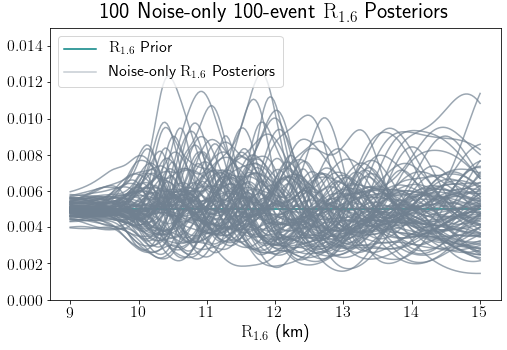

In [485]:
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('{} Noise-only '.format(Nloop)+'100-event $\mathrm{R_{1.6}}$ Posteriors')
# plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
for post_i in noise_postlist100:
    plt.plot(Rs,post_i,color='slategray',alpha=0.7,label='_nolegend_')
#     plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
#              alpha=0.7,label='_nolegend_')
grey_line = mlines.Line2D([], [], color='slategray',alpha=0.4,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[grey_line],loc='upper left')
# plt.gca().set_yticks([])
plt.ylim(0,0.015)
plt.savefig('./paper/figures/modval_noiseonly.pdf',bbox_inches='tight')
plt.savefig('./paper/figures/modval_noiseonly.png',bbox_inches='tight')
plt.show()

#### Highly-informative data

Again, not sure if this will make it in the final draft, but it's good to have.

In [18]:
## set parameters
Rtrue = 12.5
sigma_f = 0.05
nsignal = 5000
nnoise = 0

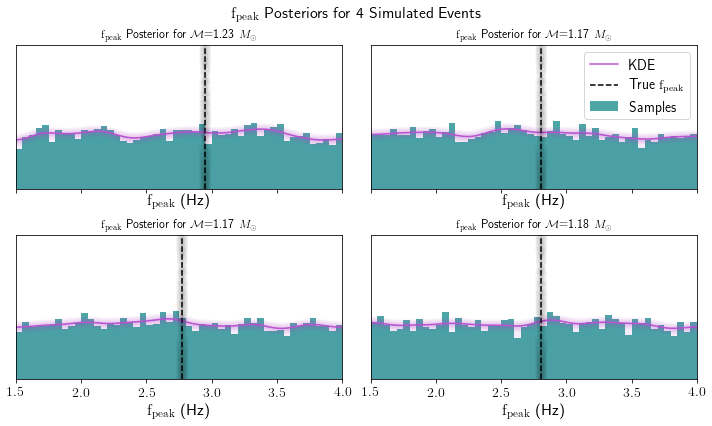

In [27]:
## make sure gen_simulated_eventdict() works lol
sim_evd_highSNR = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

100%|==========| 100/100 [03:54<00:00,  2.35s/it]


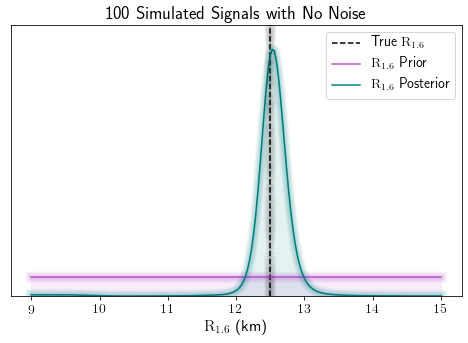

In [28]:
test_likes_highSNR = get_multievent_likelihoods(Rs,Ms,sim_evd_highSNR,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
plot_aggregate_posterior(Rs,test_likes_highSNR,Rprior_kernel,diagnostics=False,Rtrue=Rtrue,
                     title='100 Simulated Signals with No Noise',
                     legend_anchor=None,saveto=None,
                     glow=True,ax=None,Rticks=None,showplot=True)

In [41]:
noise_likelist[0].shape

(200,)

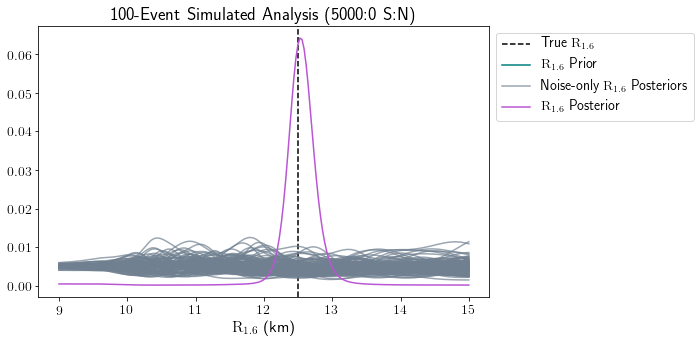

In [44]:
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('{}-Event Simulated Analysis (5000:0 S:N)'.format(100))
plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
for like_i in noise_likelist:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.7,label='_nolegend_')
plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(test_likes_highSNR),Rprior_kernel),color='mediumorchid',label='_nolegend_')
orchid_line = mlines.Line2D([], [], color='mediumorchid',
                            label='$\mathrm{R_{1.6}}$'+' Posterior')
teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[teal_line,orchid_line],bbox_to_anchor=(1,1))
# plt.gca().set_yticks([])
plt.show()

Looks gucci, stanley tucci. 

Out of curiosity, how low can we go?

In [439]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 1
nnoise = 5000

In [440]:
SNR_metalist = []
for count in [1,5,10,25,50,100]:
    nsignal = count
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=False)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    SNR_metalist.append(test_likes_i)

100%|==========| 100/100 [03:57<00:00,  2.38s/it]


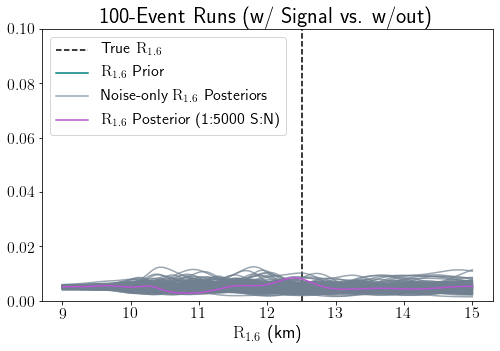

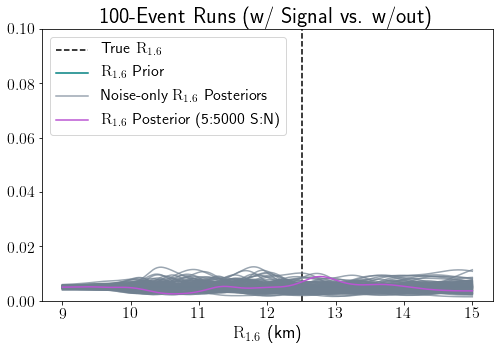

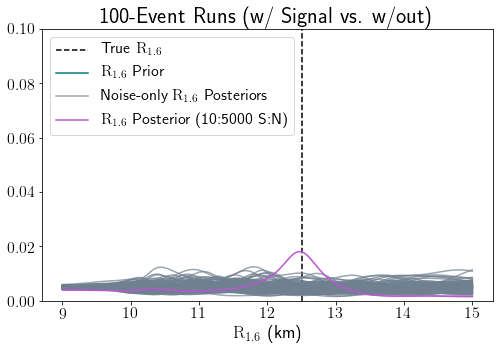

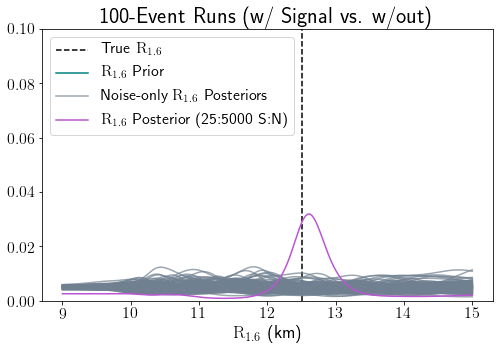

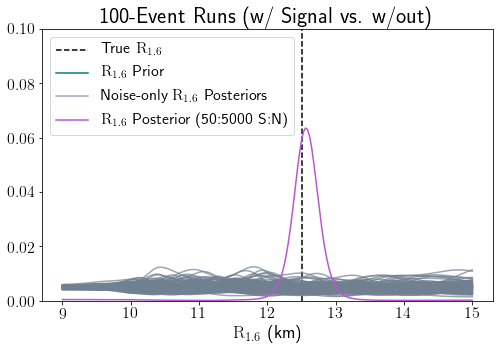

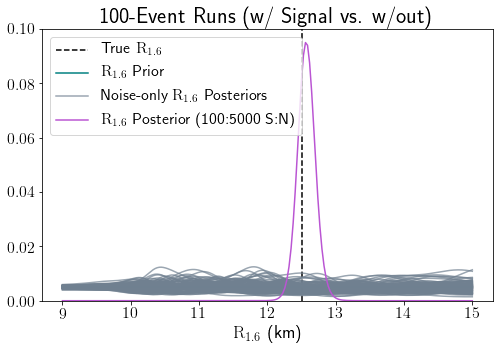

In [442]:
for i, count in enumerate([1,5,10,25,50,100]):
    plt.figure()
    plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
    plt.title('{}-Event Runs (w/ Signal vs. w/out)'.format(100))
    plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
    plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
    for like_i in noise_likelist:
        plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
                 alpha=0.7,label='_nolegend_')
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(SNR_metalist[i]),Rprior_kernel),color='mediumorchid',label='_nolegend_')
    orchid_line = mlines.Line2D([], [], color='mediumorchid',
                                label='$\mathrm{R_{1.6}}$'+' Posterior ({}:{} S:N)'.format(count,nnoise))
    gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles+[gray_line,orchid_line],loc='upper left')#bbox_to_anchor=(1,1))
#     plt.gca().set_yticks([])
    plt.ylim(0,0.1)
    plt.show()

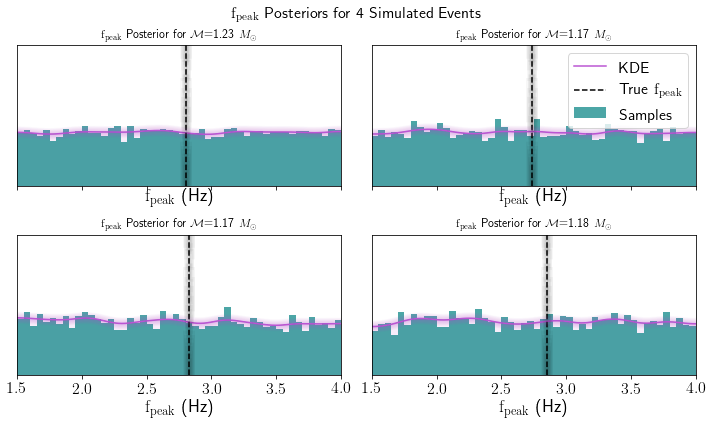

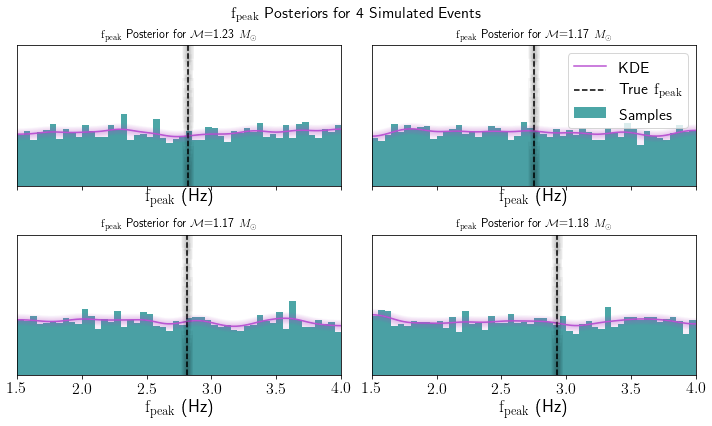

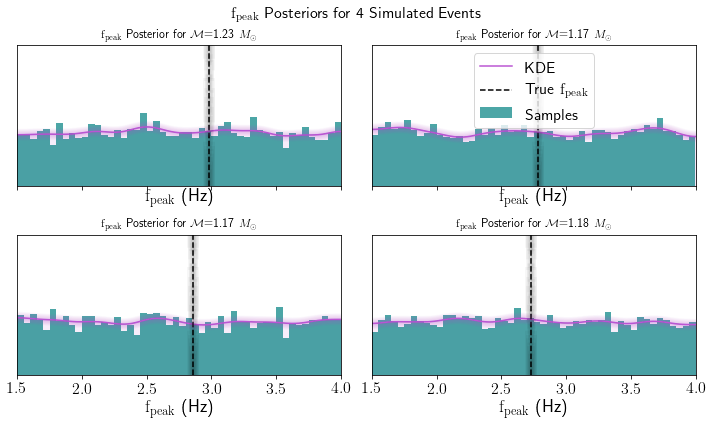

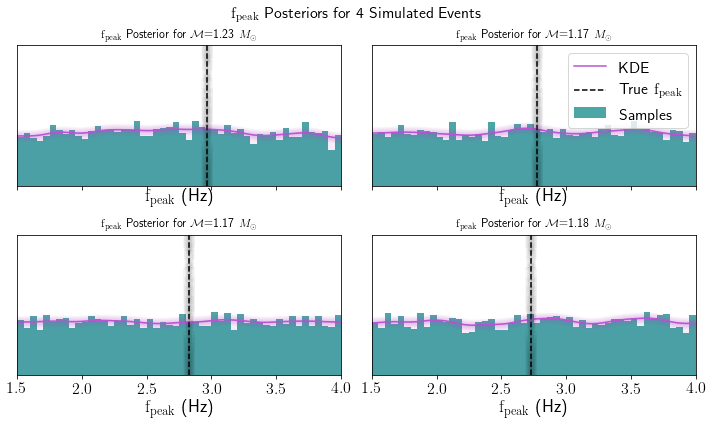

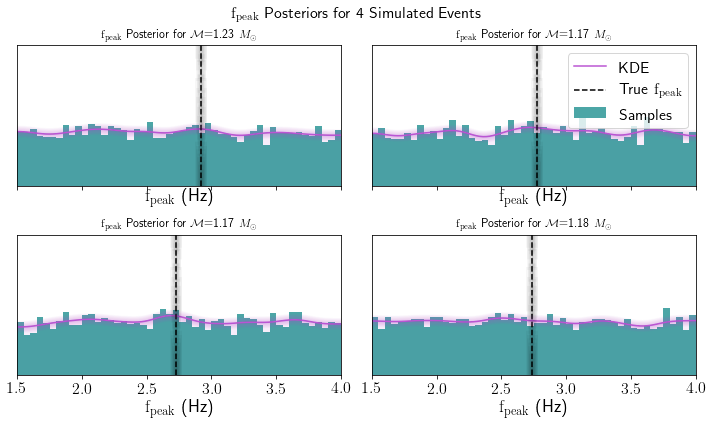

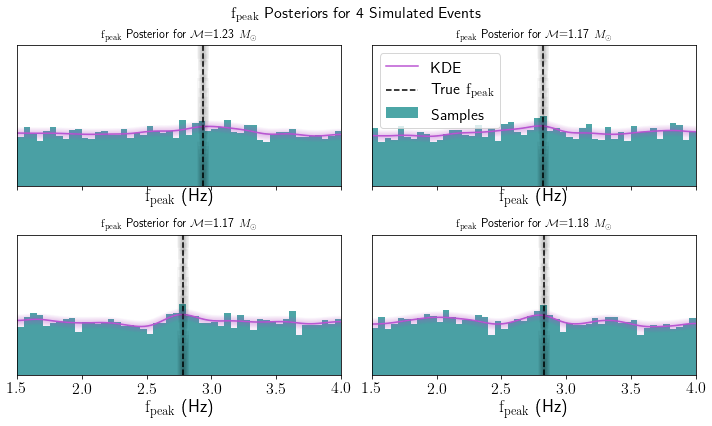

In [443]:
for count in [1,5,10,25,50,100]:
    nsignal = count
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

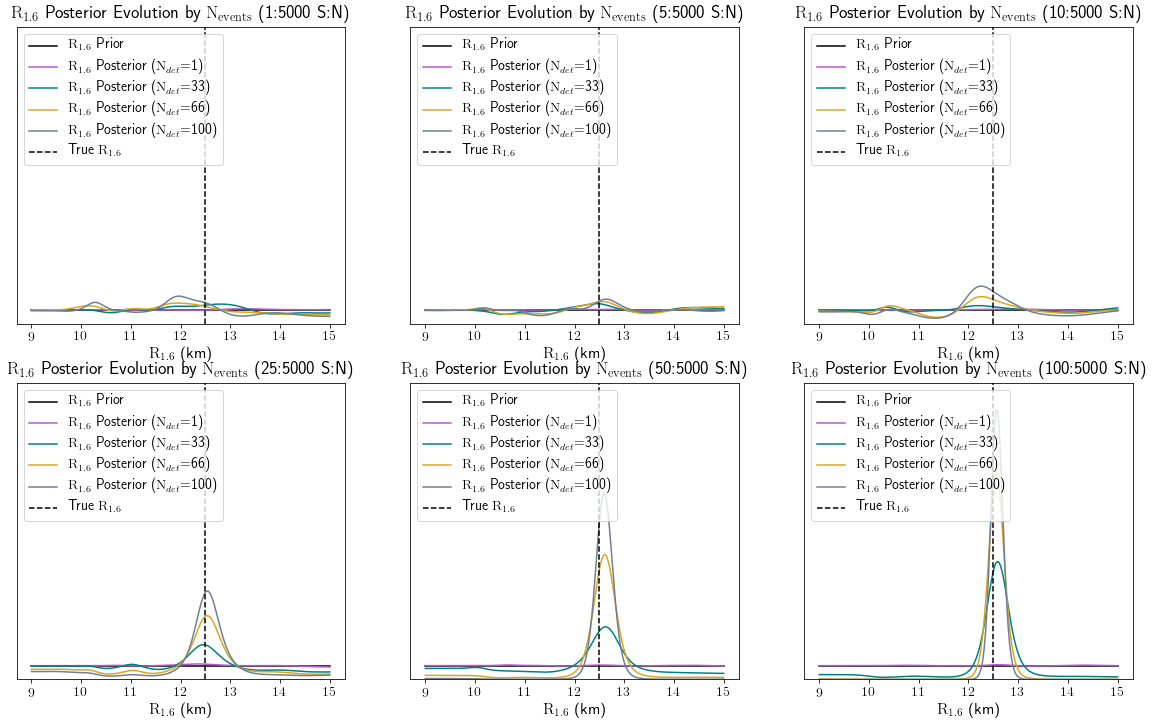

In [49]:
fig, axes = plt.subplots(2,3,figsize=(20,12),sharey=True)
for (i, count), ax in zip(enumerate([1,5,10,25,50,100]),axes.flatten()):
    plot_posterior_by_Nevents(Rs,SNR_metalist[i],Rprior_kernel,[1,33,66,100],ax=ax,Rtrue=Rtrue,legend_loc='upper left',
                             title='$\mathrm{R_{1.6}}$ Posterior Evolution by $\mathrm{N_{events}}$'+' ({}:{} S:N)'.format(count,nnoise))

In [444]:
sim_evd_i.keys()

dict_keys(['1.23-1', '1.17-1', '1.17-2', '1.18-1', '1.17-3', '1.17-4', '1.13-1', '1.12-1', '1.17-5', '1.12-2', '1.19-1', '1.16-1', '1.14-1', '1.13-2', '1.14-2', '1.15-1', '1.08', '1.26', '1.13-3', '1.09-1', '1.17-6', '1.22-1', '1.06', '1.07', '1.13-4', '1.15-2', '1.19-2', '1.16-2', '1.18-2', '1.17-7', '1.19-3', '1.21-1', '1.11-1', '1.14-3', '1.02', '1.16-3', '1.21-2', '1.15-3', '1.19-4', '1.13-5', '1.11-2', '1.12-3', '1.20-1', '1.04', '1.19-5', '1.18-3', '1.14-4', '1.14-5', '1.18-4', '1.12-4', '1.14-6', '1.09-2', '1.15-4', '1.21-3', '1.12-5', '1.16-4', '1.09-3', '1.22-2', '1.11-3', '1.15-5', '1.18-5', '1.16-5', '1.20-2', '1.20-3', '1.19-6', '1.11-4', '1.10-1', '1.12-6', '1.31', '1.20-4', '1.13-6', '1.18-6', '1.13-7', '1.21-4', '1.16-6', '1.23-2', '1.23-3', '1.22-3', '1.10-2', '1.23-4', '1.01', '1.21-5', '1.21-6', '1.16-7', '1.12-7', '1.11-5', '1.12-8', '1.14-7', '1.19-7', '1.18-7', '1.14-8', '1.20-5', '1.18-8', '0.97', '1.14-9', '1.18-9', '1.21-7', '1.13-8', '1.09-4', '1.15-6'])

In [445]:
dict_list = []
for i, count in enumerate([1,5,10,25,50,100]):
    nsignal = count
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=False)
    dict_list.append(sim_evd_i)

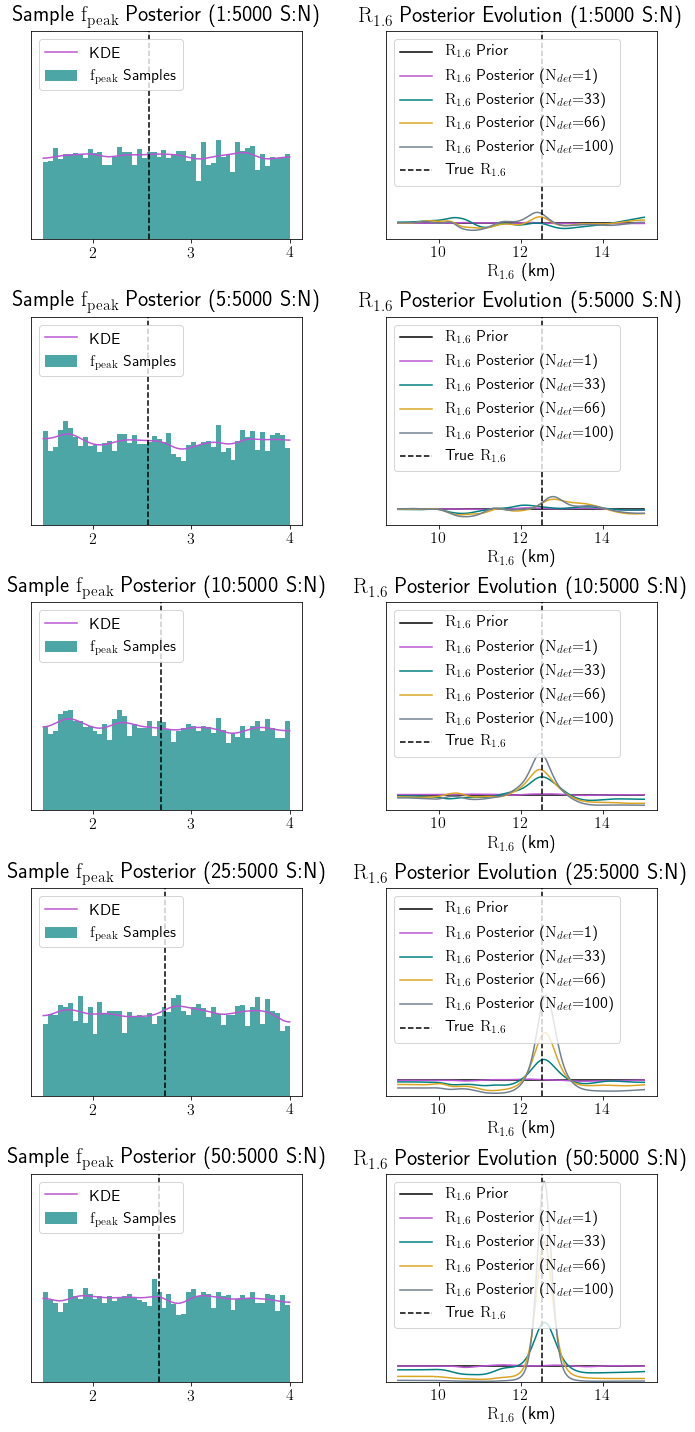

In [446]:
fig, axes = plt.subplots(5,2,figsize=(10,20),sharey=False)
for (i, count), sim_evd_i in zip(enumerate([1,5,10,25,50]),dict_list[:-1]):
    ax1 = axes[i][0]
    ax2 = axes[i][1]
#     nsignal = count
#     sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
#                                   use_prior='array',prior=fprior.samples,
#                                   kde_boundary='Reflection',kde_bandwidth=bandwidth,
#                                   plot='smallset',glow=True,saveto=None,showplot=False)
    firstkey = '1.11-1'
    samples_i1 = sim_evd_i[firstkey]['fchains']
    ftrue_i1 = sim_evd_i[firstkey]['ftrue']
    kde_i1 = sim_evd_i[firstkey]['kde']
    ax1.hist(samples_i1,density=True,bins=50,color='teal',alpha=0.7,label='$\mathrm{f_{peak}}$ Samples')
    ax1.plot(fs,kde_i1.pdf(fs),color='mediumorchid',label='KDE')
    ax1.axvline(ftrue_i1,color='k',ls='--')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0,1)
    ax1.set_yticks([])
    ax1.set_title('Sample $\mathrm{f_{peak}}$'+' Posterior ({}:{} S:N)'.format(count,nnoise))
    plot_posterior_by_Nevents(Rs,SNR_metalist[i],Rprior_kernel,[1,33,66,100],ax=ax2,Rtrue=Rtrue,legend_loc='upper left',
                             title='$\mathrm{R_{1.6}}$'+' Posterior Evolution ({}:{} S:N)'.format(count,nnoise))
    ax2.set_ylim(0,0.066)

plt.tight_layout()
plt.show()

In [447]:
dict_list[0].keys()

dict_keys(['1.23-1', '1.17-1', '1.17-2', '1.18-1', '1.17-3', '1.17-4', '1.13-1', '1.12-1', '1.17-5', '1.12-2', '1.19-1', '1.16-1', '1.14-1', '1.13-2', '1.14-2', '1.15-1', '1.08', '1.26', '1.13-3', '1.09-1', '1.17-6', '1.22-1', '1.06', '1.07', '1.13-4', '1.15-2', '1.19-2', '1.16-2', '1.18-2', '1.17-7', '1.19-3', '1.21-1', '1.11-1', '1.14-3', '1.02', '1.16-3', '1.21-2', '1.15-3', '1.19-4', '1.13-5', '1.11-2', '1.12-3', '1.20-1', '1.04', '1.19-5', '1.18-3', '1.14-4', '1.14-5', '1.18-4', '1.12-4', '1.14-6', '1.09-2', '1.15-4', '1.21-3', '1.12-5', '1.16-4', '1.09-3', '1.22-2', '1.11-3', '1.15-5', '1.18-5', '1.16-5', '1.20-2', '1.20-3', '1.19-6', '1.11-4', '1.10-1', '1.12-6', '1.31', '1.20-4', '1.13-6', '1.18-6', '1.13-7', '1.21-4', '1.16-6', '1.23-2', '1.23-3', '1.22-3', '1.10-2', '1.23-4', '1.01', '1.21-5', '1.21-6', '1.16-7', '1.12-7', '1.11-5', '1.12-8', '1.14-7', '1.19-7', '1.18-7', '1.14-8', '1.20-5', '1.18-8', '0.97', '1.14-9', '1.18-9', '1.21-7', '1.13-8', '1.09-4', '1.15-6'])

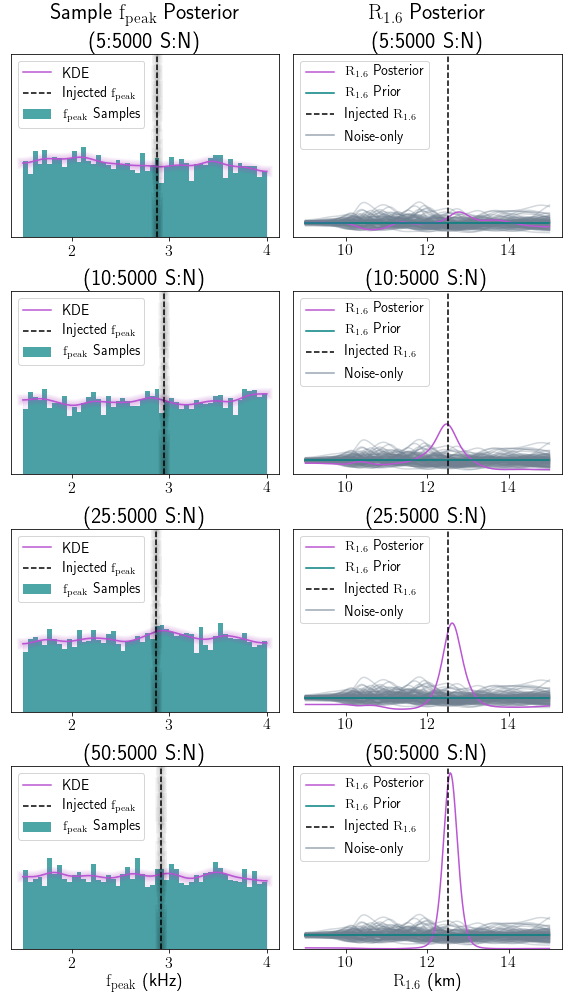

In [483]:
idxs = [1,2,3,4]
scount_list = [1,5,10,25,50,100]
fig, axes = plt.subplots(len(idxs),2,figsize=(8,14),sharey=False)#,gridspec_kw={"height_ratios":[0.001,1,1,1,1]})
# axes[0,0].axis('off')
# axes[0,0].set_title("Sample $\mathrm{f_{peak}}$ Posterior")
# axes[0,1].axis('off')
# axes[0,1].set_title("$\mathrm{R_{1.6}}$ Posterior")
# for (i, count), sim_evd_i in zip(enumerate([scount_list[ii] for ii in idx]),[dict_list[ii] for ii in idx]):
for i, idx in enumerate(idxs):
    count = scount_list[idx]
    sim_evd_i = dict_list[idx]
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    firstkey = '1.23-1'
    samples_i1 = sim_evd_i[firstkey]['fchains']
    ftrue_i1 = sim_evd_i[firstkey]['ftrue']
    kde_i1 = sim_evd_i[firstkey]['kde']
    ax1.hist(samples_i1,density=True,bins=50,color='teal',alpha=0.7,label='$\mathrm{f_{peak}}$ Samples')
    ax1.plot(fs,kde_i1.pdf(fs),color='mediumorchid',label='KDE')
    ax1.axvline(ftrue_i1,color='k',ls='--',label='Injected $\mathrm{f_{peak}}$')
    ax1.legend(loc='upper left',fontsize=14)
    ax1.set_ylim(0,1)
    ax1.set_yticks([])
    if i==0:
        ax1.set_title("Sample $\mathrm{f_{peak}}$ Posterior\n"+'({}:{} S:N)'.format(count,nnoise))
    else:
        ax1.set_title('({}:{} S:N)'.format(count,nnoise))
    mplcyberpunk.add_glow_effects(ax1)
    for like_i in noise_likelist:
        ax2.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
                 alpha=0.3,label='_nolegend_')
    ax2.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(SNR_metalist[idx]),Rprior_kernel),color='mediumorchid',
             label='$\mathrm{R_{1.6}}$ Posterior')
    ax2.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),color='teal',label='$\mathrm{R_{1.6}}$ Prior')
    ax2.axvline(Rtrue,color='k',ls='--',label='Injected $\mathrm{R_{1.6}}$')
#     orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                                 label='$\mathrm{R_{1.6}}$'+' Posterior'.format(count,nnoise))
    gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only')
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles=handles+[gray_line],loc='upper left',fontsize=14)
    ax2.set_ylim(0,0.066)
    if i==0:
        ax2.set_title("$\mathrm{R_{1.6}}$ Posterior\n"+'({}:{} S:N)'.format(count,nnoise))
    else:
        ax2.set_title('({}:{} S:N)'.format(count,nnoise))
    ax2.set_yticks([])
    if idx == idxs[-1]:
        ax1.set_xlabel('$\mathrm{f_{peak}}$ (kHz)')
        ax2.set_xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.tight_layout()
plt.savefig('./paper/figures/mod_val_sidebyside_10panel.pdf',bbox_inches='tight')
plt.savefig('./paper/figures/mod_val_sidebyside_10panel.png',bbox_inches='tight')
plt.show()

In [449]:
for ii in idxs:
    print('N_s = {}'.format(scount_list[ii]))
    get_post_stats(get_posterior(Rs,get_aggregate_likelihood(SNR_metalist[ii]),Rprior_kernel),Rs,latex=True)

N_s = 5
$\R=12.10^{+2.69}_{-2.95}$
N_s = 10
$\R=11.89^{+2.66}_{-2.70}$
N_s = 25
$\R=12.32^{+2.28}_{-3.03}$
N_s = 50
$\R=12.52^{+0.52}_{-0.81}$


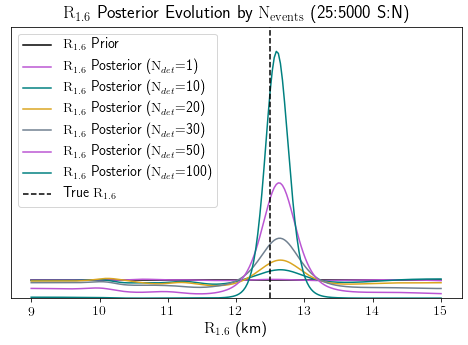

In [57]:
plot_posterior_by_Nevents(Rs,SNR_metalist[-2],Rprior_kernel,[1,10,20,30,50,100],Rtrue=Rtrue,legend_loc='upper left',
                             title='$\mathrm{R_{1.6}}$ Posterior Evolution by $\mathrm{N_{events}}$'+' ({}:{} S:N)'.format(25,nnoise))

## Check N-event scaling of C.I.s

In [58]:
help(get_post_stats)

Help on function get_post_stats in module hbpm_utils:

get_post_stats(post_dist, Rs, bounds=(0.025, 0.975), verbose=True, latex=False)
    Function to get the posterior mean and confidence interval (default 95%).
    
    Arguments:
        post_dist (array) : R_1.6 posterior distribution
        Rs (array) : R values at which post_dist is evaluated
        bounds (tuple) : (lower limit,upper limit) of confidence interval. Default gives 95% C.I..
        verbose (bool) : Whether to print results.
        latex (bool) : If printing results, whether to output as an easily copied LaTeX string.
        
    Returns:
        mean (float) : Posterior mean
        lower (float) : Lower confidence interval bound
        upper (float) : Upper confidence interval bound



### 68% C.I. Width

In [96]:
scaling_dict = {}
for scount,(j,likelist) in zip(scount_list,enumerate(SNR_metalist)):
    CL_arr = np.zeros((100,3))
    for i in range(100):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    scaling_dict[str(scount)] = CL_arr
        

In [97]:
start = (scaling_dict[str(scount)][:,2] - scaling_dict[str(scount)][:,1])[0]

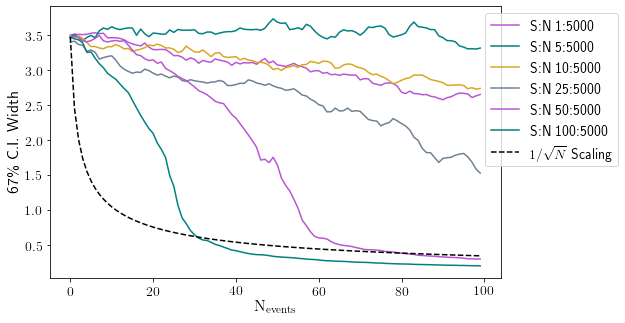

In [98]:
plt.figure()
for i, scount in enumerate(scount_list):
    plt.plot(scaling_dict[str(scount)][:,2] - scaling_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,100,100)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

### 95% C.I. Width

In [99]:
scaling_dict = {}
for scount,(j,likelist) in zip(scount_list,enumerate(SNR_metalist)):
    CL_arr = np.zeros((100,3))
    for i in range(100):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.025,0.975))
    scaling_dict[str(scount)] = CL_arr
        

In [100]:
start = (scaling_dict[str(scount)][:,2] - scaling_dict[str(scount)][:,1])[0]

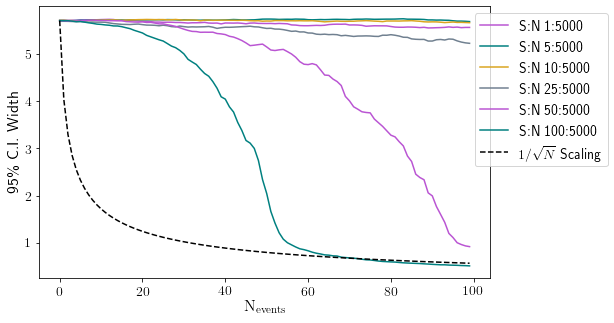

In [102]:
plt.figure()
for i, scount in enumerate(scount_list):
    plt.plot(scaling_dict[str(scount)][:,2] - scaling_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,100,100)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("95\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

## Demo: applicability across parameter space

In [410]:
## set parameters
sigma_f = 0.1
nsignal = 25
nnoise = 5000

In [411]:
Rinj_metalist = []
Rinj_dictlist = []
for R in [10,11,12,13,14]:#[9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]:
    Rtrue = R
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=False)
    Rinj_dictlist.append(sim_evd_i)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    Rinj_metalist.append(test_likes_i)

100%|==========| 100/100 [03:59<00:00,  2.39s/it]


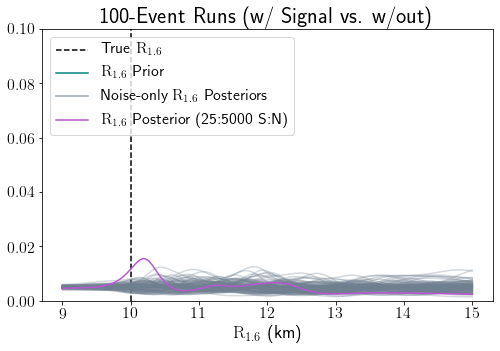

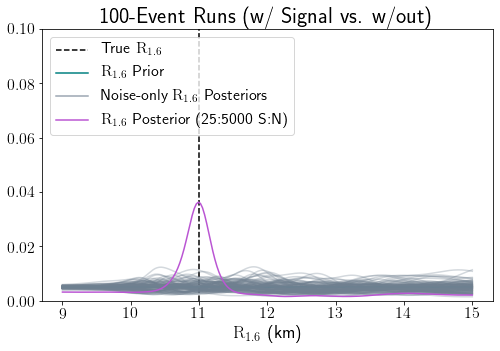

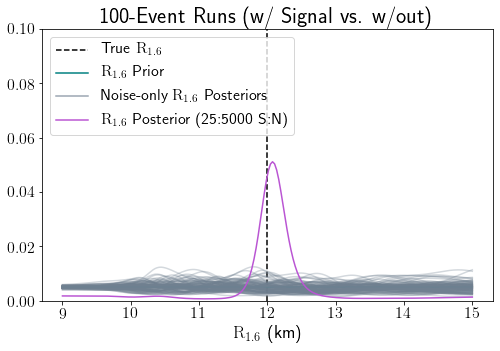

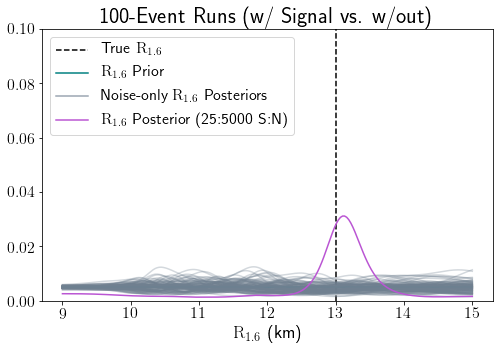

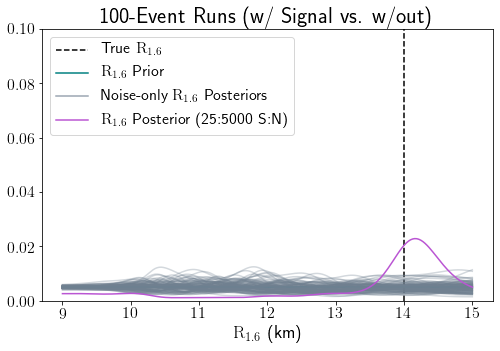

In [412]:
for i, R in enumerate([10,11,12,13,14]):#[9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]):
    plt.figure()
    plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
    plt.title('{}-Event Runs (w/ Signal vs. w/out)'.format(100))
    plt.axvline(R,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
    plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
    for like_i in noise_likelist:
        plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
                 alpha=0.3,label='_nolegend_')
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist[i]),Rprior_kernel),color='mediumorchid',label='_nolegend_')
    orchid_line = mlines.Line2D([], [], color='mediumorchid',
                                label='$\mathrm{R_{1.6}}$'+' Posterior ({}:{} S:N)'.format(25,nnoise))
    gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles+[gray_line,orchid_line],loc='upper left')#bbox_to_anchor=(1,1))
#     plt.gca().set_yticks([])
    plt.ylim(0,0.1)
    plt.show()

10
R_1.6 = 11.38 (+3.03,-2.06) km
11
R_1.6 = 11.35 (+2.97,-1.88) km
12
R_1.6 = 12.01 (+1.55,-2.13) km
13
R_1.6 = 12.69 (+1.36,-3.09) km
14
R_1.6 = 13.33 (+1.44,-3.75) km


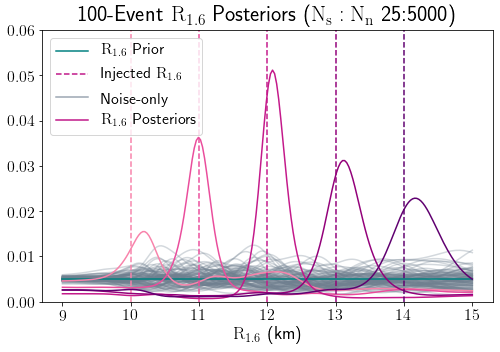

In [418]:
R2plot = [10,11,12,13,14]
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('100-Event $\mathrm{R_{1.6}}$ Posteriors ($\mathrm{N_s:N_n}$ 25:5000)')
for like_i in noise_likelist:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.3,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
cmap = matplotlib.cm.get_cmap('RdPu')
# for R in Rs2:
#     colnum = (R - Rs2.min())/(Rs2.max() - Rs2.min())
#     plt.plot(Ms2,empirical_relation_f(R,Ms2),label='$\mathrm{R_{1.6}}$'+' = {:0.2f} (V)'.format(R),color='slategrey')
#     plt.plot(Ms2,empirical_relation_new(R,Ms2),label='$\mathrm{R_{1.6}}$'+' = {:0.2f} (J)'.format(R),color=cmap(colnum))
for i, R in enumerate([10,11,12,13,14]):#[9.5,10,10.5,11,11.5,12,12.5,13,13.5,14,14.5]):
    if R in R2plot:
        print(R)
        get_post_stats(get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist[i]),Rprior_kernel),Rs,bounds=(0.05,0.95))
#         colnum = (R - R2plot.min())/(R2plot.max() - R2plot.min())
        colnum = (R - 6.5)/(8)
        plt.axvline(R,ls='--',color=cmap(colnum),label='__nolabel__')
        plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist[i]),Rprior_kernel),
                 color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior ({}:{} S:N)'.format(25,nnoise))
gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only')
cmap_solid = mlines.Line2D([], [], color=cmap(0.7),label='$\mathrm{R_{1.6}}$ Posteriors')
cmap_dashed = mlines.Line2D([], [], color=cmap(0.7),ls='--',label='Injected $\mathrm{R_{1.6}}$')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[cmap_dashed,gray_line,cmap_solid],loc='upper left')#bbox_to_anchor=(1,1))
#     plt.gca().set_yticks([])
# plt.axvline(R,ls='--',color='k',label='True $\mathrm{R_{1.6}}$'
plt.ylim(0,0.06)
# plt.savefig('./paper/figures/mod_val_Rrange.pdf',bbox_inches='tight')
# plt.savefig('./paper/figures/mod_val_Rrange.png',bbox_inches='tight')
plt.show()

Repeat at higher signal strength...

In [54]:
## set parameters
sigma_f = 0.1
nsignal = 50
nnoise = 5000

In [55]:
Rinj_metalist2 = []
Rinj_dictlist2 = []
for R in [10,11,12,13,14]:
    Rtrue = R
    sim_evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=False)
    Rinj_dictlist2.append(sim_evd_i)
    test_likes_i = get_multievent_likelihoods(Rs,Ms,sim_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    Rinj_metalist2.append(test_likes_i)

10
R_1.6 = 11.32 (+3.33,-1.88) km
11
R_1.6 = 11.08 (+0.34,-0.34) km
12
R_1.6 = 12.04 (+0.33,-0.31) km
13
R_1.6 = 13.06 (+0.46,-0.40) km
14
R_1.6 = 14.09 (+0.61,-0.50) km


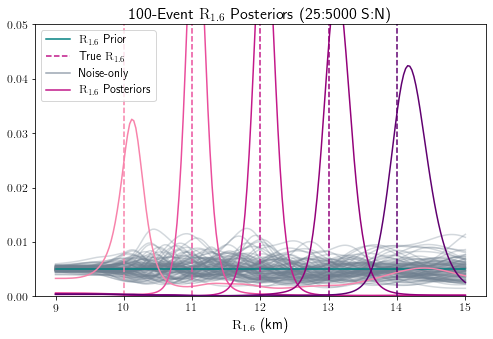

In [56]:
R2plot = [10,11,12,13,14]
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('100-Event $\mathrm{R_{1.6}}$ Posteriors (25:5000 S:N)')
for like_i in noise_likelist100:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.3,label='_nolegend_')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
cmap = matplotlib.cm.get_cmap('RdPu')
# for R in Rs2:
#     colnum = (R - Rs2.min())/(Rs2.max() - Rs2.min())
#     plt.plot(Ms2,empirical_relation_f(R,Ms2),label='$\mathrm{R_{1.6}}$'+' = {:0.2f} (V)'.format(R),color='slategrey')
#     plt.plot(Ms2,empirical_relation_new(R,Ms2),label='$\mathrm{R_{1.6}}$'+' = {:0.2f} (J)'.format(R),color=cmap(colnum))
for i, R in enumerate([10,11,12,13,14]):
    if R in R2plot:
        print(R)
        get_post_stats(get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist2[i]),Rprior_kernel),Rs,bounds=(0.05,0.95))
#         colnum = (R - R2plot.min())/(R2plot.max() - R2plot.min())
        colnum = (R - 6.5)/(8)
        plt.axvline(R,ls='--',color=cmap(colnum),label='__nolabel__')
        plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(Rinj_metalist2[i]),Rprior_kernel),
                 color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior ({}:{} S:N)'.format(25,nnoise))
gray_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only')
cmap_solid = mlines.Line2D([], [], color=cmap(0.7),label='$\mathrm{R_{1.6}}$ Posteriors')
cmap_dashed = mlines.Line2D([], [], color=cmap(0.7),ls='--',label='True $\mathrm{R_{1.6}}$')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[cmap_dashed,gray_line,cmap_solid],loc='upper left')#bbox_to_anchor=(1,1))
#     plt.gca().set_yticks([])
# plt.axvline(R,ls='--',color='k',label='True $\mathrm{R_{1.6}}$'
plt.ylim(0,0.05)
# plt.savefig('./paper/figures/mod_val_Rrange2.pdf',bbox_inches='tight')
# plt.savefig('./paper/figures/mod_val_Rrange2.png',bbox_inches='tight')
plt.show()

# Deep Search
High-N repeat of a few earlier tests.

#### Generate Events

In [486]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 25
nnoise = 5000

In [487]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N = 1000
m1s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
m2s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
Mlist = calc_Mchirp(m1s,m2s)

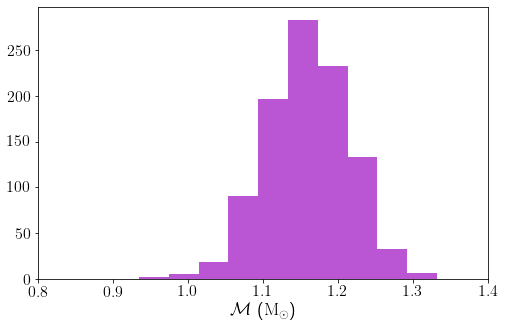

In [488]:
plt.figure()
plt.hist(Mlist)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

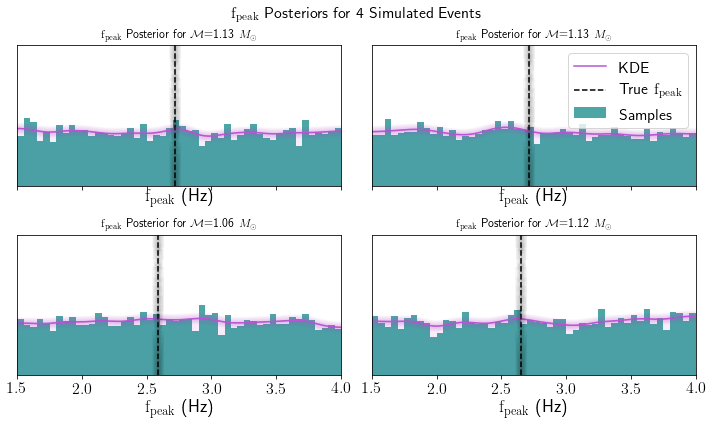

In [489]:
## make sure gen_simulated_eventdict() works lol
sim_evd = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)

In [490]:
Mf_list = np.array([[sim_evd[key]['mchirp'],sim_evd[key]['ftrue']] for key in sim_evd.keys()])

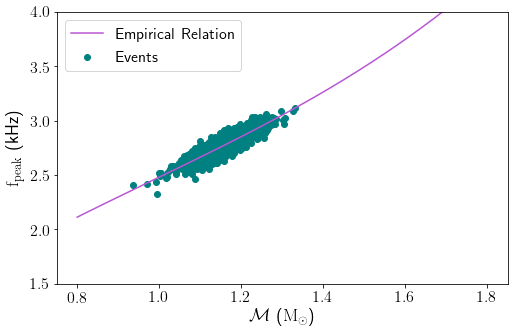

In [491]:
plt.figure()
plt.plot(Ms,empirical_relation_f(Rtrue,Ms),label='Empirical Relation')
plt.scatter(Mf_list[:,0],Mf_list[:,1],label='Events',color='teal')
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.ylabel('$\mathrm{f_{peak}}$ (kHz)')
plt.ylim(1.5,4)
plt.legend()
plt.show()

#### Run Analysis

In [109]:
deep_likes = get_multievent_likelihoods(Rs,Ms,sim_evd,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)

100%|==========| 1000/1000 [45:58<00:00,  2.76s/it]


/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm_v2/hbpm_utils/hbpm_utils.py:1387: RuntimeWarning: invalid value encountered in true_divide
  aggregate = unnormed_aggregate/np.sum(unnormed_aggregate)


Aggregate likelihood calculation has encountered overflow. Switching to iterative aggregation...


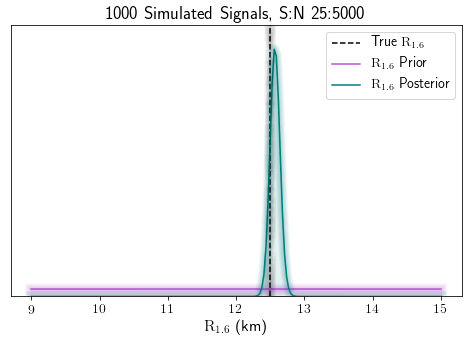

In [110]:
plot_aggregate_posterior(Rs,deep_likes,Rprior_kernel,diagnostics=False,Rtrue=Rtrue,
                     title='1000 Simulated Signals, S:N 25:5000',
                     legend_anchor=None,saveto=None,
                     glow=True,ax=None,Rticks=None,showplot=True)

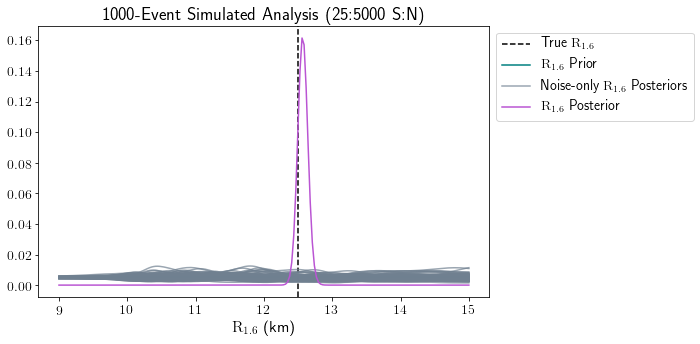

In [296]:
plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')
plt.title('{}-Event Simulated Analysis (25:5000 S:N)'.format(1000))
plt.axvline(Rtrue,ls='--',color='k',label='True $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
for like_i in noise_likelist:
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
             alpha=0.7,label='_nolegend_')
plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(deep_likes),Rprior_kernel),color='mediumorchid',label='_nolegend_')
orchid_line = mlines.Line2D([], [], color='mediumorchid',
                            label='$\mathrm{R_{1.6}}$'+' Posterior')
teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[teal_line,orchid_line],bbox_to_anchor=(1,1))
# plt.gca().set_yticks([])
plt.show()

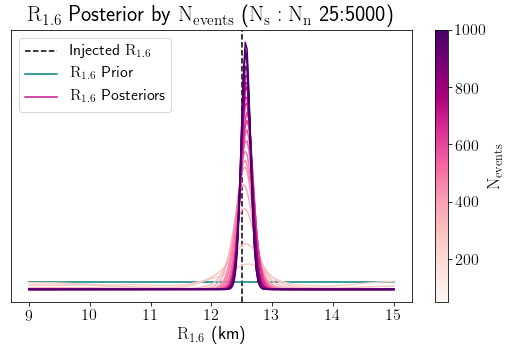

In [421]:
cmap = matplotlib.cm.get_cmap('RdPu')

plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')#,labelpad=-1)
plt.title('$\mathrm{R_{1.6}}$ Posterior by $\mathrm{N_{events}}$ ($\mathrm{N_s:N_n}$ 25:5000)')
plt.axvline(Rtrue,ls='--',color='k',label='Injected $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
# for like_i in noise_likelist:
#     plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
#              alpha=0.7,label='_nolegend_')
for i in np.arange(51,1002,50):
    colnum = (i+200)/1201
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(deep_likes[:i]),Rprior_kernel),
             color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior')
orchid_line = mlines.Line2D([], [], color=cmap(0.7),
                            label='$\mathrm{R_{1.6}}$'+' Posteriors')
# teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[orchid_line],loc='upper left')#,bbox_to_anchor=(1,1))
norm = matplotlib.colors.Normalize(vmin=0, vmax=1200)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_clim(50,1000)
cbar = plt.colorbar(mappable,
             orientation='vertical', label='$\mathrm{N}_{\mathrm{events}}$',fraction=0.06)
# cbar.set_clim(50,1000)
# plt.colorbar()
plt.gca().set_yticks([])
# plt.tight_layout()
plt.savefig('./paper/figures/post_Nevents_1k.pdf',bbox_inches='tight')
plt.savefig('./paper/figures/post_Nevents_1k.png',bbox_inches='tight')
plt.show()

### 68% C.I. Width

In [253]:
CL_arr_68 = np.zeros((1000,3))
for i in range(1000):
    CL_arr_68[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(deep_likes[:i+1]),Rprior_kernel),
                                 Rs,latex=False,verbose=False,bounds=(0.16,0.74))
widths_68 = CL_arr_68[:,2] - CL_arr_68[:,1]
start_68 = widths_68[0]

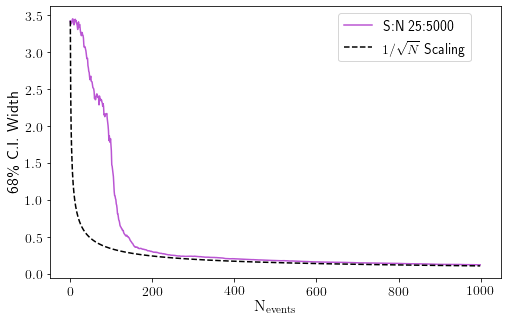

In [299]:
plt.figure()
plt.plot(CL_arr_68[:,2] - CL_arr_68[:,1],label="S:N {}:5000".format(nsignal))
plt.plot(start_68/np.sqrt(np.linspace(1,1000,1000)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("68\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()   

### 95% C.I. Width

In [255]:
CL_arr_95 = np.zeros((1000,3))
for i in range(1000):
    CL_arr_95[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(deep_likes[:i+1]),Rprior_kernel),
                                 Rs,latex=False,verbose=False,bounds=(0.025,0.975))
widths_95 = CL_arr_95[:,2] - CL_arr_95[:,1]
start_95 = widths_95[0]

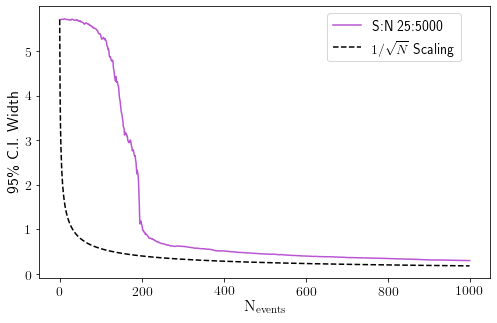

In [300]:
plt.figure()
plt.plot(CL_arr_95[:,2] - CL_arr_95[:,1],label="S:N {}:5000".format(nsignal))
plt.plot(start_95/np.sqrt(np.linspace(1,1000,1000)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("95\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
# plt.xlim(400,1000)
# plt.ylim(0,1)
plt.show()   

Normalise and plot together:

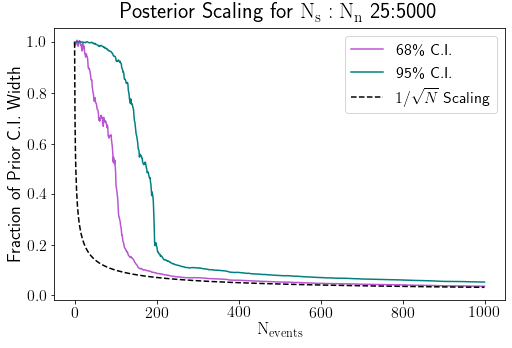

In [376]:
plt.figure()
plt.plot((CL_arr_68[:,2] - CL_arr_68[:,1])/start_68,label="68\% C.I.")
plt.plot((CL_arr_95[:,2] - CL_arr_95[:,1])/start_95,label="95\% C.I.")
plt.plot(1/np.sqrt(np.linspace(1,1000,1000)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(loc='upper right')
plt.ylabel("Fraction of Prior C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.title("Posterior Scaling for $\mathrm{N_s:N_n}$ 25:5000")
# plt.xlim(400,1000)
# plt.ylim(0,1)
plt.savefig('./paper/figures/post_scale_1k.pdf',bbox_inches='tight')
plt.savefig('./paper/figures/post_scale_1k.png',bbox_inches='tight')
plt.show()   

### 1st Derivative

In [264]:
a = [1,2,3,4,5,6,7,8]
a[2::2]

[3, 5, 7]

In [263]:
## downsample to get overall trend without lower limit from grid resolution
widths_68_ds = widths_68[::10]
widths_95_ds = widths_95[::10]

In [291]:
deltas_68 = widths_68_ds[1:] - widths_68_ds[:-1]
deltas_95 = widths_95_ds[1:] - widths_95_ds[:-1]
deltas_rootN_95 = start_95/np.sqrt(np.linspace(1,1000,1000))[::10][1:] - start_95/np.sqrt(np.linspace(1,1000,1000))[::10][:-1]
deltas_rootN_68 = start_68/np.sqrt(np.linspace(1,1000,1000))[::10][1:] - start_68/np.sqrt(np.linspace(1,1000,1000))[::10][:-1]

In [281]:
mask = (np.abs(deltas_95) > 1e-16)
events = np.linspace(1,1000,990)[::10]
events_masked = events[mask]
deltas_95_masked = deltas_95[mask]

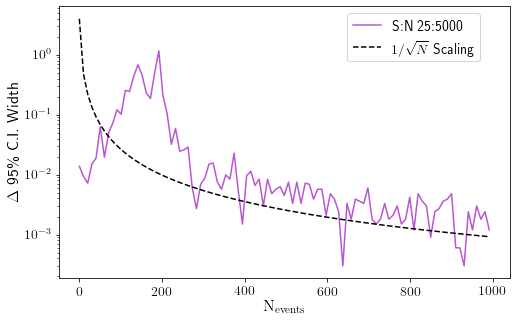

In [301]:
plt.figure()
# plt.plot(events_masked,medfilt(np.abs(deltas_95_masked),kernel_size=11),label="S:N {}:5000".format(50))
plt.plot(events_masked,np.abs(deltas_95_masked),label="S:N {}:5000".format(nsignal))
plt.plot(events_masked,np.abs(deltas_rootN_95[mask]),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel(" $\Delta$ 95\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
# plt.ylim(1e-5,1e-1)
plt.yscale('log')
plt.show()   

#### Do the same for 3 strengths (low mid high)

In [492]:
deep_dict = {}
for nsignal_val in [5,25,50]:
    deep_dict[str(nsignal_val)] = {}
    evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal_val,nnoise,rng,scatter=0.053,
                                                                 use_prior='array',prior=fprior.samples,
                                                                 kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                                                 plot=None,glow=True,saveto=None,showplot=True)
    deep_dict[str(nsignal_val)]['evd'] = evd_i
    likes_i = get_multievent_likelihoods(Rs,Ms,evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    deep_dict[str(nsignal_val)]['likes'] = likes_i

100%|==========| 1000/1000 [1:04:42<00:00,  3.88s/it]


In [494]:
import dill

In [497]:
with open('./paper/model_validation_data/1000event_synthetic.pickle',"wb") as file:
    dill.dump(deep_dict,file)

In [498]:
with open('./paper/model_validation_data/1000event_synthetic.pickle',"rb") as file:
    loaded_dict = dill.load(file)

In [503]:
deep_scale_dict = {}
deep_scounts = [5,25,50]
N = 1000
for scount in deep_scounts:
    CL_arr = np.zeros((N,3))
    likelist = loaded_dict[str(scount)]['likes']
    for i in range(N):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    deep_scale_dict[str(scount)] = CL_arr

In [504]:
start = (deep_scale_dict[str(5)][:,2] - deep_scale_dict[str(5)][:,1])[0]

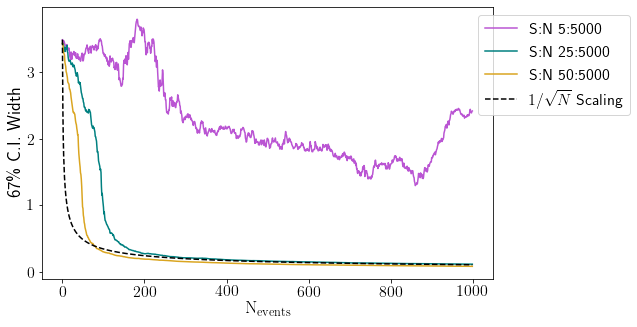

In [507]:
plt.figure()
for i, scount in enumerate(deep_scounts):
    
    plt.plot(deep_scale_dict[str(scount)][:,2] - deep_scale_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,1000,1000)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

Help on function plot_posterior_by_Nevents in module hbpm_utils:

plot_posterior_by_Nevents(Rs, likelihood_list, Rprior, Ns, ax=None, Rtrue=None, title=None, legend_anchor=None, legend_loc=None, glow=False, saveto=None, showplot=True)
    Function to plot the evolution of the posterior by event.
    
    Arguments:
        Rs (array) : R values at which to compute and plot posterior.
        likelihood_list (list of arrays) : List containing the likelihood p(data_i|R16) for each event.
        Rprior (kernel) : R_1.6 prior KDE
        diagnostics (bool) : Whether to also create diagnostic plot showing posterior-prior difference.
        Ns (list) : Which N_events to plot the posterior for.
        ax (matplotlib Axes) : Axes object on which to plot if specified.
        Rtrue (float) : Injected value of R_1.6, if any
        title (str) : Plot title
        legend_anchor (tuple) : Legend placement. Passed to pyplot's legend bbox_to_anchor.
        legend_loc (str) : Alternate legend pl

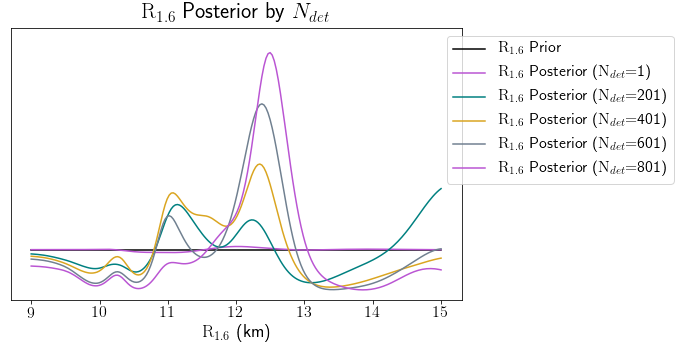

In [515]:
help(plot_posterior_by_Nevents)
plot_posterior_by_Nevents(Rs,loaded_dict[str(5)]['likes'],st.uniform(loc=9,scale=6),Ns=np.arange(1,1000,200),
                         legend_anchor=(0.95,1))

In [516]:
## add a scount 10 run
for nsignal_val in [10]:
    deep_dict[str(nsignal_val)] = {}
    evd_i = gen_simulated_eventdict(Mlist,Rtrue,sigma_f,nsignal_val,nnoise,rng,scatter=0.053,
                                                                 use_prior='array',prior=fprior.samples,
                                                                 kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                                                 plot=None,glow=True,saveto=None,showplot=True)
    deep_dict[str(nsignal_val)]['evd'] = evd_i
    likes_i = get_multievent_likelihoods(Rs,Ms,evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    deep_dict[str(nsignal_val)]['likes'] = likes_i

100%|==========| 1000/1000 [1:06:46<00:00,  4.01s/it]


In [518]:
deep_scale_dict = {}
deep_scounts = [5,10,25,50]
N = 1000
for scount in deep_scounts:
    CL_arr = np.zeros((N,3))
    likelist = deep_dict[str(scount)]['likes']
    for i in range(N):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    deep_scale_dict[str(scount)] = CL_arr

In [519]:
start = (deep_scale_dict[str(5)][:,2] - deep_scale_dict[str(5)][:,1])[0]

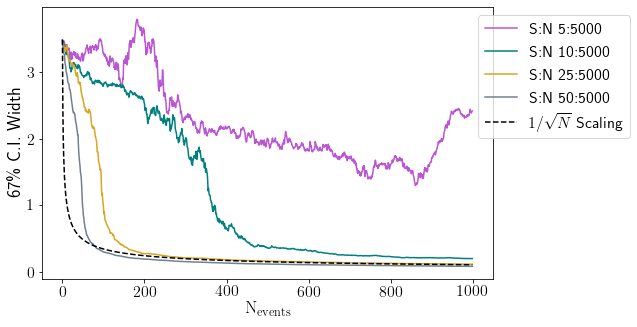

In [520]:
plt.figure()
for i, scount in enumerate(deep_scounts):
    
    plt.plot(deep_scale_dict[str(scount)][:,2] - deep_scale_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,1000,1000)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

$N_s=1000$ didn't quite converge... let's add another set of 500 events.

In [521]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1

In [522]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N_new = 500
m1s_new = st.norm.rvs(loc=1.33,scale=0.09,size=N_new,random_state=rng)
m2s_new = st.norm.rvs(loc=1.33,scale=0.09,size=N_new,random_state=rng)
Mlist_new = calc_Mchirp(m1s_new,m2s_new)

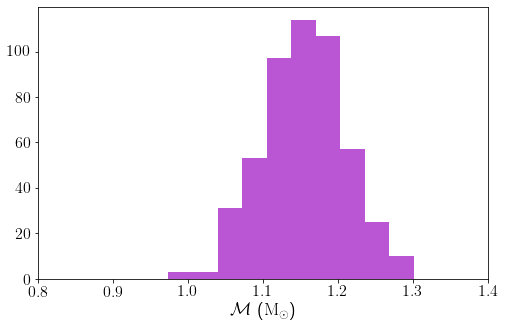

In [523]:
plt.figure()
plt.hist(Mlist_new)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

In [527]:
deep_dict_add = {}
for nsignal_val in [5,10,25,50]:
    deep_dict_add[str(nsignal_val)] = {}
    evd_i = gen_simulated_eventdict(Mlist_new,Rtrue,sigma_f,nsignal_val,nnoise,rng,scatter=0.053,
                                                                 use_prior='array',prior=fprior.samples,
                                                                 kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                                                 plot=None,glow=True,saveto=None,showplot=True)
    deep_dict_add[str(nsignal_val)]['evd'] = evd_i
    likes_i = get_multievent_likelihoods(Rs,Ms,evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    deep_dict_add[str(nsignal_val)]['likes'] = likes_i

100%|==========| 500/500 [25:11<00:00,  3.02s/it]


In [528]:
combo_deep_dict = {}
for nsignal_val in [5,10,25,50]:
    combo_deep_dict[str(nsignal_val)] = {}
    combo_deep_dict[str(nsignal_val)]['likes'] = [*deep_dict[str(nsignal_val)]['likes'],
                                                  *deep_dict_add[str(nsignal_val)]['likes']]

In [529]:
combo_deep_scale_dict = {}
combo_deep_scounts = [5,10,25,50]
N = 1500
for scount in combo_deep_scounts:
    CL_arr = np.zeros((N,3))
    likelist = combo_deep_dict[str(scount)]['likes']
    for i in range(N):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    combo_deep_scale_dict[str(scount)] = CL_arr

In [530]:
combo_start = (combo_deep_scale_dict[str(5)][:,2] - combo_deep_scale_dict[str(5)][:,1])[0]

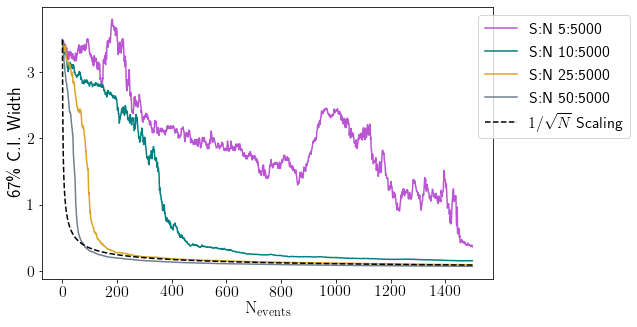

In [531]:
plt.figure()
for i, scount in enumerate(combo_deep_scounts):
    
    plt.plot(combo_deep_scale_dict[str(scount)][:,2] - combo_deep_scale_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

Still not there. KYLO_MORE.gif

In [532]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N_new2 = 500
m1s_new2 = st.norm.rvs(loc=1.33,scale=0.09,size=N_new2,random_state=rng)
m2s_new2 = st.norm.rvs(loc=1.33,scale=0.09,size=N_new2,random_state=rng)
Mlist_new2 = calc_Mchirp(m1s_new2,m2s_new2)

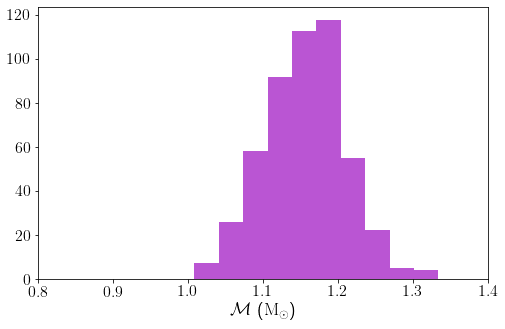

In [533]:
plt.figure()
plt.hist(Mlist_new2)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

In [534]:
deep_dict_add2 = {}
for nsignal_val in [5,10,25,50]:
    deep_dict_add2[str(nsignal_val)] = {}
    evd_i = gen_simulated_eventdict(Mlist_new2,Rtrue,sigma_f,nsignal_val,nnoise,rng,scatter=0.053,
                                                                 use_prior='array',prior=fprior.samples,
                                                                 kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                                                 plot=None,glow=True,saveto=None,showplot=True)
    deep_dict_add2[str(nsignal_val)]['evd'] = evd_i
    likes_i = get_multievent_likelihoods(Rs,Ms,evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    deep_dict_add2[str(nsignal_val)]['likes'] = likes_i

100%|==========| 500/500 [19:14<00:00,  2.31s/it]


In [535]:
combo2_deep_dict = {}
for nsignal_val in [5,10,25,50]:
    combo2_deep_dict[str(nsignal_val)] = {}
    combo2_deep_dict[str(nsignal_val)]['likes'] = [*deep_dict[str(nsignal_val)]['likes'],
                                                  *deep_dict_add[str(nsignal_val)]['likes'],
                                                  *deep_dict_add2[str(nsignal_val)]['likes']]

In [536]:
combo2_deep_scale_dict = {}
combo2_deep_scounts = [5,10,25,50]
N = 2000
for scount in combo2_deep_scounts:
    CL_arr = np.zeros((N,3))
    likelist = combo2_deep_dict[str(scount)]['likes']
    for i in range(N):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    combo2_deep_scale_dict[str(scount)] = CL_arr

In [537]:
combo2_start = (combo2_deep_scale_dict[str(5)][:,2] - combo2_deep_scale_dict[str(5)][:,1])[0]

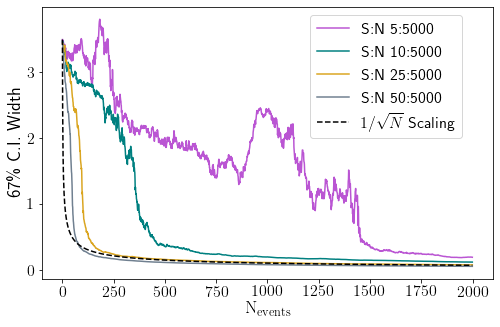

In [538]:
plt.figure()
for i, scount in enumerate(combo2_deep_scounts):
    
    plt.plot(combo2_deep_scale_dict[str(scount)][:,2] - combo2_deep_scale_dict[str(scount)][:,1],label="S:N {}:5000".format(scount))
plt.plot(start/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    

Just out of curiousity, I want to see the N_s = 5 plot...

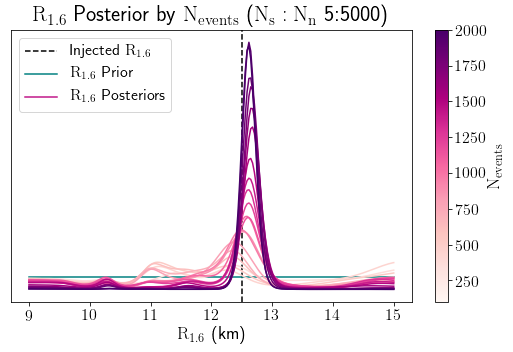

In [542]:
cmap = matplotlib.cm.get_cmap('RdPu')

plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')#,labelpad=-1)
plt.title('$\mathrm{R_{1.6}}$ Posterior by $\mathrm{N_{events}}$ ($\mathrm{N_s:N_n}$ 5:5000)')
plt.axvline(Rtrue,ls='--',color='k',label='Injected $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
# for like_i in noise_likelist:
#     plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
#              alpha=0.7,label='_nolegend_')
for i in np.arange(101,2002,100):
    colnum = (i+200)/2201
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(combo2_deep_dict['5']['likes'][:i]),Rprior_kernel),
             color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior')
orchid_line = mlines.Line2D([], [], color=cmap(0.7),
                            label='$\mathrm{R_{1.6}}$'+' Posteriors')
# teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[orchid_line],loc='upper left')#,bbox_to_anchor=(1,1))
norm = matplotlib.colors.Normalize(vmin=0, vmax=2200)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_clim(100,2000)
cbar = plt.colorbar(mappable,
             orientation='vertical', label='$\mathrm{N}_{\mathrm{events}}$',fraction=0.06)
# cbar.set_clim(50,1000)
# plt.colorbar()
plt.gca().set_yticks([])
# plt.tight_layout()
# plt.savefig('./paper/figures/post_Nevents_1k.pdf',bbox_inches='tight')
# plt.savefig('./paper/figures/post_Nevents_1k.png',bbox_inches='tight')
plt.show()

Experiment: what happens if a portion (say half!) of the events have no info whatsoever?

#### Generate Events

In [543]:
## set parameters
Rtrue = 12.5
sigma_f = 0.1
nsignal = 25
nnoise = 5000

In [544]:
## get random selection of chirp masses
## for kicks, let's use the same Mchirp prior as Petrov+2021 (which in turn is that of LRR)
N = 1000
m1s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
m2s = st.norm.rvs(loc=1.33,scale=0.09,size=N,random_state=rng)
Mlist = calc_Mchirp(m1s,m2s)

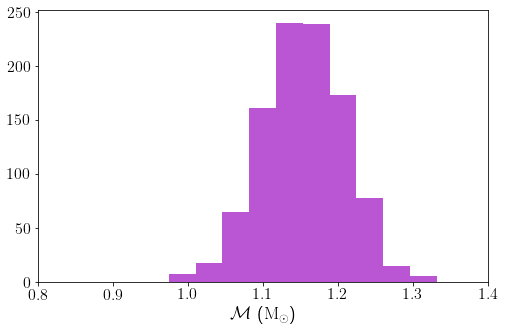

In [545]:
plt.figure()
plt.hist(Mlist)
plt.xlim(0.8,1.4)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.show()

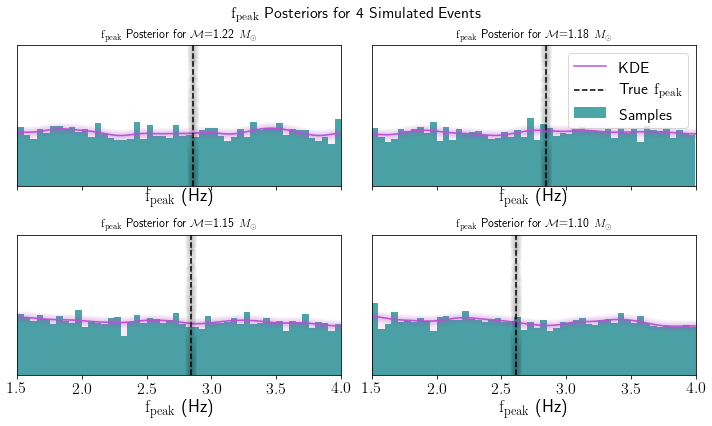

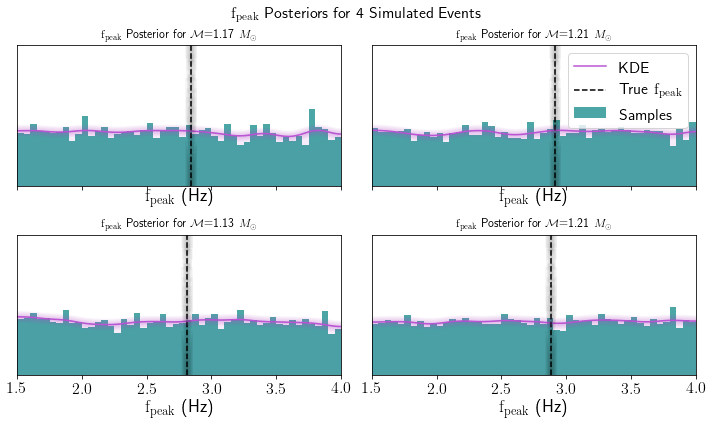

In [551]:
## half of the events, randomly drawn, will have a signal; the rest will not
good_idx = rng.choice(np.arange(N),size=500,replace=False)
good_Mlist = Mlist[good_idx]
empty_Mlist = np.delete(Mlist,good_idx)
good_evd = gen_simulated_eventdict(good_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True)
empty_evd = gen_simulated_eventdict(empty_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                  use_prior='array',prior=fprior.samples,
                                  kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                  plot='smallset',glow=True,saveto=None,showplot=True,
                                   nosignal=True)

In [552]:
good_Mf_list = np.array([[good_evd[key]['mchirp'],good_evd[key]['ftrue']] for key in good_evd.keys()])
empty_Mf_list = np.array([[empty_evd[key]['mchirp'],empty_evd[key]['ftrue']] for key in empty_evd.keys()])

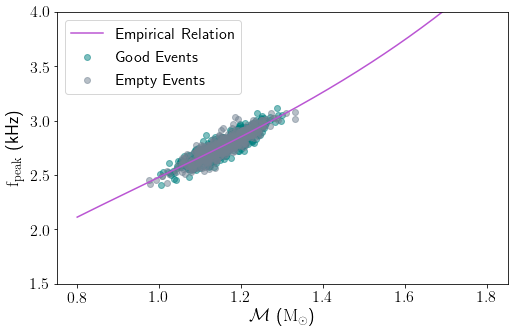

In [554]:
plt.figure()
plt.plot(Ms,empirical_relation_f(Rtrue,Ms),label='Empirical Relation')
plt.scatter(good_Mf_list[:,0],good_Mf_list[:,1],label='Good Events',color='teal',alpha=0.5)
plt.scatter(empty_Mf_list[:,0],empty_Mf_list[:,1],label='Empty Events',color='slategrey',alpha=0.5)
plt.xlabel('$\mathcal{M}$ ($\mathrm{M_{\odot}}$)')
plt.ylabel('$\mathrm{f_{peak}}$ (kHz)')
plt.ylim(1.5,4)
plt.legend()
plt.show()

In [561]:
len(good_evd),len(empty_evd)

(500, 500)

In [563]:
mixed_evd = good_evd.copy()
for key in empty_evd.keys():
    if key in mixed_evd.keys():
        mixed_evd[key+'-empty'] = empty_evd[key]
    else:
        mixed_evd[key] = empty_evd[key]

In [565]:
mixed_likes = get_multievent_likelihoods(Rs,Ms,mixed_evd,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)

100%|==========| 1000/1000 [54:58<00:00,  3.30s/it] 


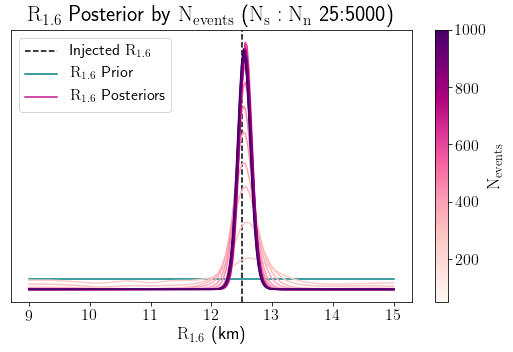

In [569]:
cmap = matplotlib.cm.get_cmap('RdPu')

plt.figure()
plt.xlabel('$\mathrm{R_{1.6}}$ (km)')#,labelpad=-1)
plt.title('$\mathrm{R_{1.6}}$ Posterior by $\mathrm{N_{events}}$ ($\mathrm{N_s:N_n}$ 25:5000)')
plt.axvline(Rtrue,ls='--',color='k',label='Injected $\mathrm{R_{1.6}}$')
plt.plot(Rs,Rprior_kernel.pdf(Rs)/np.sum(Rprior_kernel.pdf(Rs)),label='$\mathrm{R_{1.6}}$ Prior',color='teal')
# for like_i in noise_likelist:
#     plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(like_i),Rprior_kernel),color='slategray',
#              alpha=0.7,label='_nolegend_')
for i in np.arange(51,1002,50):
    colnum = (i+200)/1201
    plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(mixed_likes[:i]),Rprior_kernel),
             color=cmap(colnum),label='_nolegend_')
# orchid_line = mlines.Line2D([], [], color='mediumorchid',
#                             label='$\mathrm{R_{1.6}}$'+' Posterior')
orchid_line = mlines.Line2D([], [], color=cmap(0.7),
                            label='$\mathrm{R_{1.6}}$'+' Posteriors')
# teal_line = mlines.Line2D([], [], color='slategray',alpha=0.7,label='Noise-only $\mathrm{R_{1.6}}$ Posteriors')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles+[orchid_line],loc='upper left')#,bbox_to_anchor=(1,1))
norm = matplotlib.colors.Normalize(vmin=0, vmax=1200)
mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_clim(50,1000)
cbar = plt.colorbar(mappable,
             orientation='vertical', label='$\mathrm{N}_{\mathrm{events}}$',fraction=0.06)
# cbar.set_clim(50,1000)
# plt.colorbar()
plt.gca().set_yticks([])
# plt.tight_layout()
# plt.savefig('./paper/figures/post_Nevents_1k.pdf',bbox_inches='tight')
# plt.savefig('./paper/figures/post_Nevents_1k.png',bbox_inches='tight')
plt.show()

In [570]:
CL_arr_68 = np.zeros((1000,3))
for i in range(1000):
    CL_arr_68[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(mixed_likes[:i+1]),Rprior_kernel),
                                 Rs,latex=False,verbose=False,bounds=(0.16,0.74))
widths_68 = CL_arr_68[:,2] - CL_arr_68[:,1]
start_68 = widths_68[0]

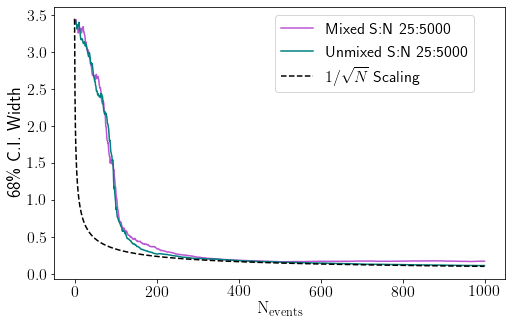

In [573]:
plt.figure()
plt.plot(CL_arr_68[:,2] - CL_arr_68[:,1],label="Mixed S:N {}:5000".format(25))
plt.plot(deep_scale_dict['25'][:,2] - deep_scale_dict['25'][:,1],label="Unmixed S:N {}:5000".format(25))
plt.plot(start_68/np.sqrt(np.linspace(1,1000,1000)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.ylabel("68\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()   

Let's look at the scaling of this!

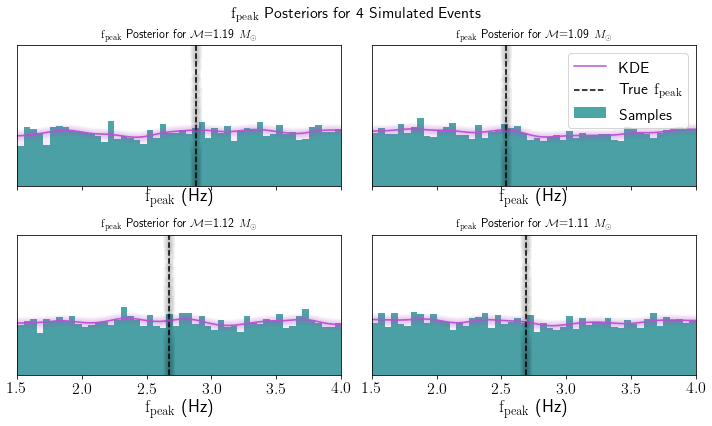

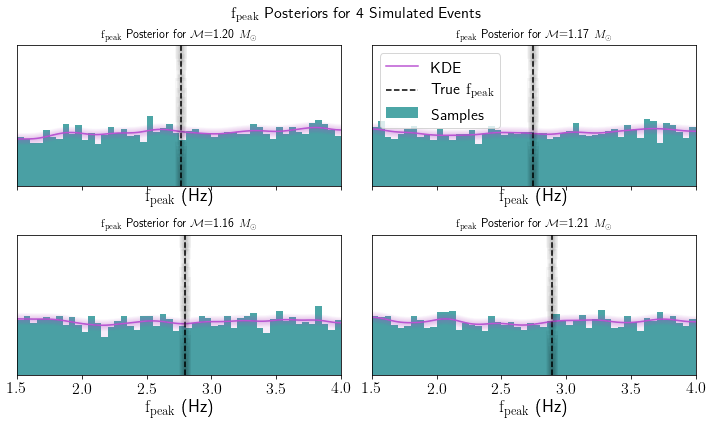

100%|==========| 1000/1000 [57:31<00:00,  3.45s/it]


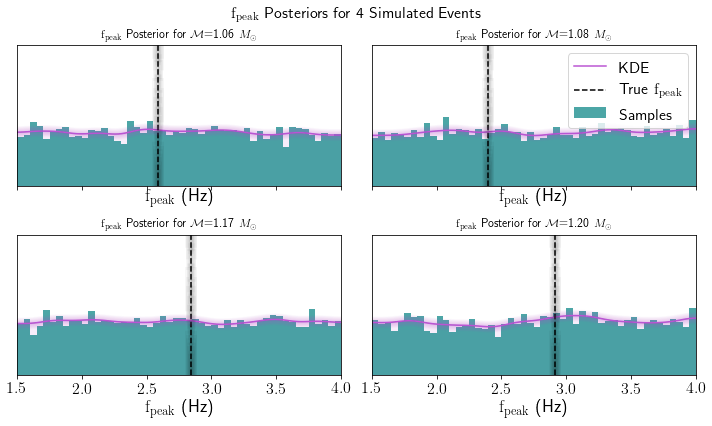

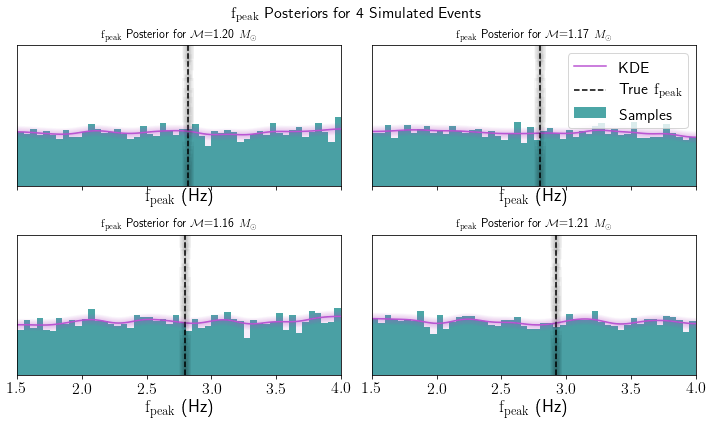

100%|==========| 1000/1000 [53:24<00:00,  3.20s/it]


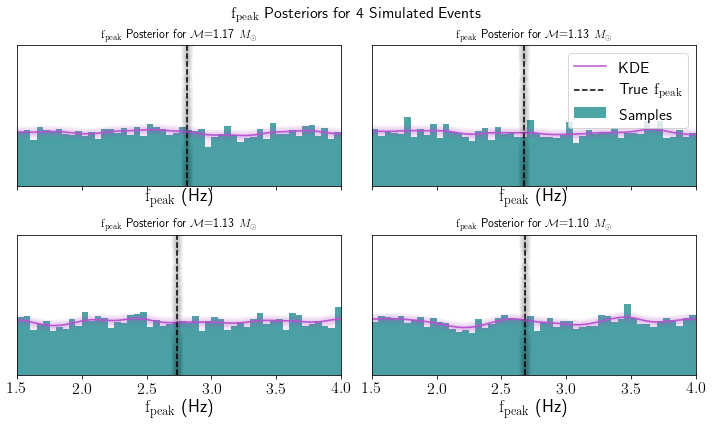

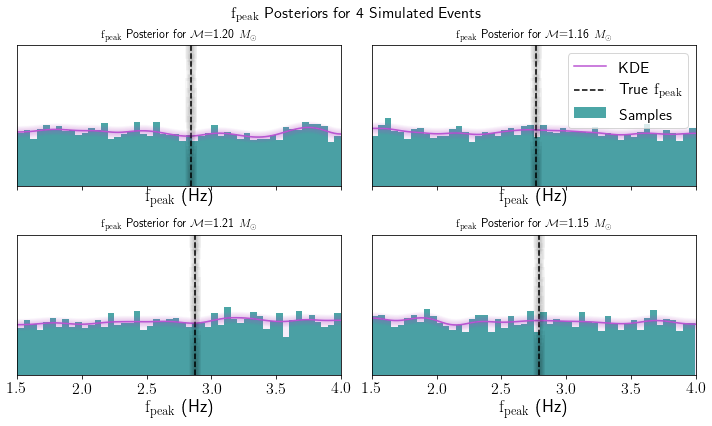

100%|==========| 1000/1000 [52:39<00:00,  3.16s/it]


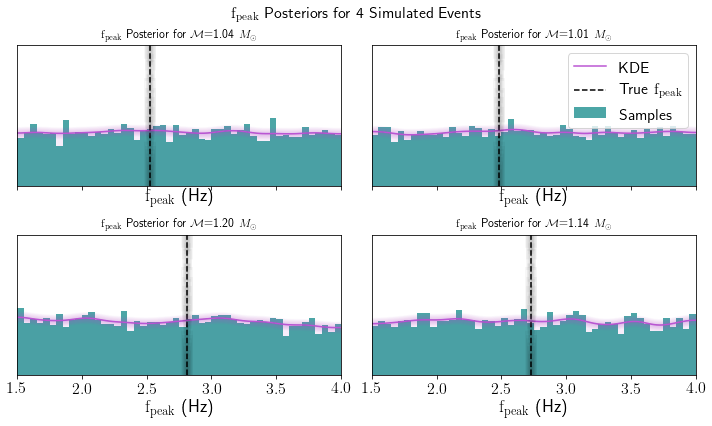

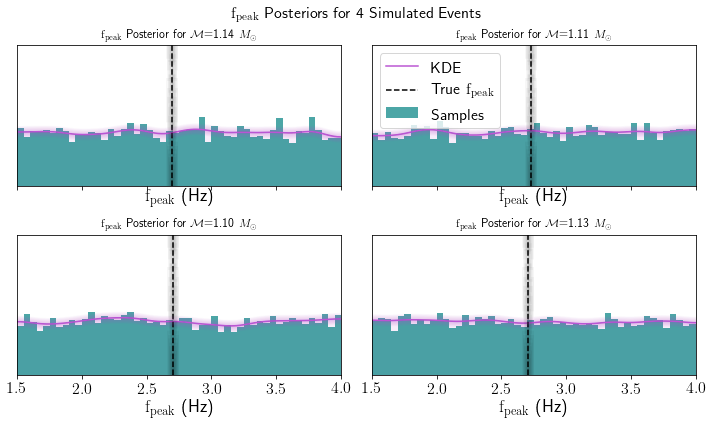

100%|==========| 1000/1000 [53:27<00:00,  3.21s/it]


In [574]:
contamination_dict = {}
contamination_dict['500'] = {}
contamination_dict['500']['likes'] = mixed_likes
for N_good in [50,100,250,750]:
    contamination_dict[str(N_good)] = {}
    good_idx = rng.choice(np.arange(N),size=N_good,replace=False)
    good_Mlist = Mlist[good_idx]
    empty_Mlist = np.delete(Mlist,good_idx)
    good_evd_i = gen_simulated_eventdict(good_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                      use_prior='array',prior=fprior.samples,
                                      kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                      plot='smallset',glow=True,saveto=None,showplot=True)
    contamination_dict[str(N_good)]['good'] = good_evd_i
    empty_evd_i = gen_simulated_eventdict(empty_Mlist,Rtrue,sigma_f,nsignal,nnoise,rng,scatter=0.053,
                                      use_prior='array',prior=fprior.samples,
                                      kde_boundary='Reflection',kde_bandwidth=bandwidth,
                                      plot='smallset',glow=True,saveto=None,showplot=True,
                                       nosignal=True)
    contamination_dict[str(N_good)]['empty'] = empty_evd_i
    mixed_evd_i = good_evd_i.copy()
    for key in empty_evd_i.keys():
        if key in mixed_evd_i.keys():
            mixed_evd_i[key+'-empty'] = empty_evd_i[key]
        else:
            mixed_evd_i[key] = empty_evd_i[key]
    contamination_dict[str(N_good)]['mixed'] = mixed_evd_i
    mixed_likes_i = get_multievent_likelihoods(Rs,Ms,mixed_evd_i,Mchirp_type='simulated',fprior=fprior,
                           Mprior=st.uniform(loc=0,scale=5),Mchirp_scaling='none',verbose=False,bootstrap=bootstrap)
    contamination_dict[str(N_good)]['likes'] = mixed_likes_i

In [577]:
mix_scale_dict = {}
mix_scounts = [50,100,250,500,750]
N = 1000
for mcount in mix_scounts:
    CL_arr = np.zeros((N,3))
    likelist = contamination_dict[str(mcount)]['likes']
    for i in range(N):
        CL_arr[i,:] = get_post_stats(get_posterior(Rs,get_aggregate_likelihood(likelist[:i+1]),Rprior_kernel),
                                     Rs,latex=False,verbose=False,bounds=(0.16,0.74))
    mix_scale_dict[str(mcount)] = CL_arr

In [578]:
mix_start = (mix_scale_dict[str(500)][:,2] - mix_scale_dict[str(500)][:,1])[0]

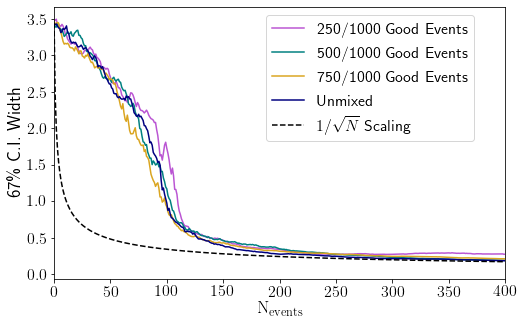

In [581]:
plt.figure()
for i, mcount in enumerate([250,500,750]):
    plt.plot(mix_scale_dict[str(mcount)][:,2] - mix_scale_dict[str(mcount)][:,1],
             label="{}/1000 Good Events".format(mcount))
plt.plot(deep_scale_dict['25'][:,2] - deep_scale_dict['25'][:,1],label="Unmixed",color='navy')
plt.plot(mix_start/np.sqrt(np.linspace(1,N,N)),label="$1/\sqrt{N}$ Scaling",color='k',ls='--')
plt.legend(bbox_to_anchor=(0.95,1))
plt.xlim(0,400)
plt.ylabel("67\% C.I. Width")
plt.xlabel("$\mathrm{N_{events}}$")
plt.show()
    